# Project 101
### PARTE 2.1 - Modelos Machine Learning

### Contenido
- [Modelado](#modelos)

    - [**2.1. Machine Learning Simple**](#1)
     - [**2.2. Machine Learning Nixtla Conjunto**](#1)

    - [Resultados](#resultados)

Para esta sección porbaremos modelar las series de tiempo utilizando tres modelos de ML: LGBM Regressor, XGboost Regressor y Random Forest Regressor. 
Asimismo, comparare los resultados obtenidos con los resultados de los modelos estadisticos de la seccion anterior.

In [30]:
import pandas as pd
import funciones_utiles 
from funciones_utiles import DataPrep, Metrics
import plotly_express as px
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  

import time
time.clock = time.time

from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from numba import njit
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean
from sklearn import preprocessing

from sklearn.metrics import mean_squared_error, mean_absolute_error

import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

__Importamos los datos__

In [31]:
df_impo_1= pd.read_csv('Data/Modelado/impo 1 - USA FLAT.csv')
df_impo_2= pd.read_csv('Data/Modelado/impo 2 - ORIENTE UPS.csv')
df_impo_3= pd.read_csv('Data/Modelado/impo 3 - CHINA LATIN LOGISTIC.csv')
df_impo_4= pd.read_csv('Data/Modelado/impo 4 - EUROPA UPS.csv')
df_impo_5= pd.read_csv('Data/Modelado/impo 5 - Courier Oriente FLAT Wish.csv')
df_impo_6= pd.read_csv('Data/Modelado/impo 6 - Impo Geobox Flat.csv')
df_impo_7= pd.read_csv('Data/Modelado/impo 7 - UPS MERCOSUR.csv')

df_expo_1= pd.read_csv('Data/Modelado/expo 1 - Exporta Simple - Puerta-Aeropuerto.csv')
df_expo_2= pd.read_csv('Data/Modelado/expo 2 - CARGA AEREA EXPO PREPAID.csv')
df_expo_3= pd.read_csv('Data/Modelado/expo 3 - CARGA AEREA EXPO - Q.csv')
df_expo_4= pd.read_csv('Data/Modelado/expo 4 - 4-Expo - Fedex Economy.csv')
df_expo_5= pd.read_csv('Data/Modelado/expo 5 - 6-Expo-UPS Express.csv')

In [32]:
comparison_tbl= pd.read_csv('Data/Modelado/comparison_tbl.csv')

##### 2.1.1 Modelado ML local
En primera instancia correré los tres modelos de ML sin tuneo de hiperparametros y corriendo cada uno disasociando las series entre si. Cada serie sera entrenada por separada, y cada modelo sera probado por cada serie. En total tres modelos por cada una. A su vez, para simplificar el analisis y la comparacion en esta primer instancia no se realizara un param grid search pero si considerare un window size de 28.

__Funciones útiles: ML Nixtla simple__

In [33]:
def ml_model(models, df, motivo, comparison_tbl):
    
    #queremos saber cuanto tiempo de procesamiento lleva correr cada modelo para eso usamos el time.clock 
    tic = time.clock()
    
    num_samples= len(df)
    train_len = int(0.8* num_samples)
    
    df[['ds']]= pd.to_datetime(df['ds'], format='%Y-%m-%d')

    df_train = df[:train_len]
    df_test= df[train_len:]

    df_train['unique_id']= 'id_00'
    df_test['unique_id']=  'id_00'
    df_train['static_0']= 72
    df_test['static_0']= 72
    df_train= df_train[['unique_id', 'ds', 'y', 'static_0']]

    fcst = MLForecast(
        models=models,
        freq='W',
        lags=[1, 2],
        lag_transforms={
            1: [expanding_mean],
        },
        target_transforms=[Differences([1])],
    )
    
    fcst.fit(df_train)
    predictions = fcst.predict(len(df_test)) 
    
    actual_values = df['y'][train_len:]
    predicted_values1 = predictions['LinearRegression']
    predicted_values2= predictions['XGBRegressor']
    predicted_values3= predictions['RandomForestRegressor']
    
    
    #definimos las metricas con las que vamos a evaluar la performance 
      
    mae1 = mean_absolute_error(actual_values, predicted_values1)
    rmse1 = np.sqrt(mean_squared_error(actual_values, predicted_values1))
    smape1 = Metrics(actual_values, predicted_values1).calculate_smape()
    
    
    mae2 = mean_absolute_error(actual_values, predicted_values2)
    rmse2 = np.sqrt(mean_squared_error(actual_values, predicted_values2))
    smape2 = Metrics(actual_values, predicted_values2).calculate_smape()
    
    
    mae3 = mean_absolute_error(actual_values, predicted_values3)
    rmse3 = np.sqrt(mean_squared_error(actual_values, predicted_values3))
    smape3 = Metrics(actual_values, predicted_values3).calculate_smape()
    
    toc =  time.clock() #frenamos el cronometro y a continuacion creamos la variable que guarda el tiempo transcurrido desde que empezo a correr el modelo hasta q termino
    exetime = '{0:.4f}'.format(toc-tic)
    
    
    # creamos un diccionario donde guardar las variables y resultados del modelo que corrimos
    raw_data1 = {
            'Serie': [motivo, motivo, motivo],
            'Modelo': ['LinearRegression','XGBRegressor','RandomForestRegressor'],
            'MAE':  [mae1 ,mae2, mae3],
            'RMSE': [rmse1,rmse2, rmse3],
            'sMAPE': [smape1,smape2, smape3], 
            'Processing Time': [exetime, exetime, exetime],
            }
    
     #creamos un df de una sola row correspondiente a los datos del modelo corrido         
    df_tbl = pd.DataFrame(raw_data1)
    #le hacemos un append al df que ya definimos afuera de la funcion y que sera ingresado como input, de esta forma cada vez q corremos un modelo los datos se guardan en una nueva linea sin afectar los datos anteriores.
    comparison_tbl = pd.concat([comparison_tbl, df_tbl], ignore_index=True)
    
    #graficamos los resultados obtenidos 
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
    sns.lineplot(x=df.ds[train_len:num_samples], y=df.y[train_len:num_samples], marker='o', label='test', color='grey')
    sns.lineplot(x=df.ds[:train_len], y=df_train.y, marker='o', label='train')
    sns.lineplot(x=predictions.ds, y=predictions['LinearRegression'], marker='o', label='pred')
    ax.set_xlim([df.ds.iloc[0], df.ds.iloc[-1]])
    ax.set_title(f'{motivo}: LinearRegression Model')
    plt.tight_layout()
    plt.show()
    
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
    sns.lineplot(x=df.ds[train_len:num_samples], y=df.y[train_len:num_samples], marker='o', label='test', color='grey')
    sns.lineplot(x=df.ds[:train_len], y=df_train.y, marker='o', label='train')
    sns.lineplot(x=predictions.ds, y=predictions['XGBRegressor'], marker='o', label='pred')
    ax.set_xlim([df.ds.iloc[0], df.ds.iloc[-1]])
    ax.set_title(f'{motivo}: XGBRegressor Model')
    plt.tight_layout()
    plt.show()
    
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
    sns.lineplot(x=df.ds[train_len:num_samples], y=df.y[train_len:num_samples], marker='o', label='test', color='grey')
    sns.lineplot(x=df.ds[:train_len], y=df_train.y, marker='o', label='train')
    sns.lineplot(x=predictions.ds, y=predictions['RandomForestRegressor'], marker='o', label='pred')
    ax.set_xlim([df.ds.iloc[0], df.ds.iloc[-1]])
    ax.set_title(f'{motivo}: RandomForestRegressor Model')
    plt.tight_layout()
    plt.show()
    
    
    return comparison_tbl

Los modelos de ML elegidos son: 
- Linear Regressor
- XG Boost Regressor
- Random Forest Regressor

In [34]:
models = [
    LinearRegression(),
    xgb.XGBRegressor(),
    RandomForestRegressor(random_state=0),
]

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_14812\3453618423.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['unique_id']= 'id_00'
C:\Users\Bravo15\AppData\Local\Temp\ipykernel_14812\3453618423.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['unique_id']=  'id_00'
C:\Users\Bravo15\AppData\Local\Temp\ipykernel_14812\3453618423.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


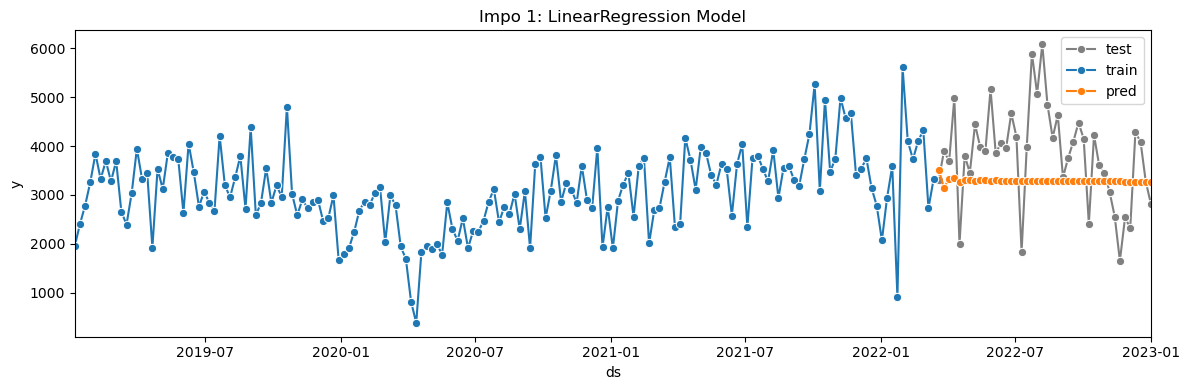

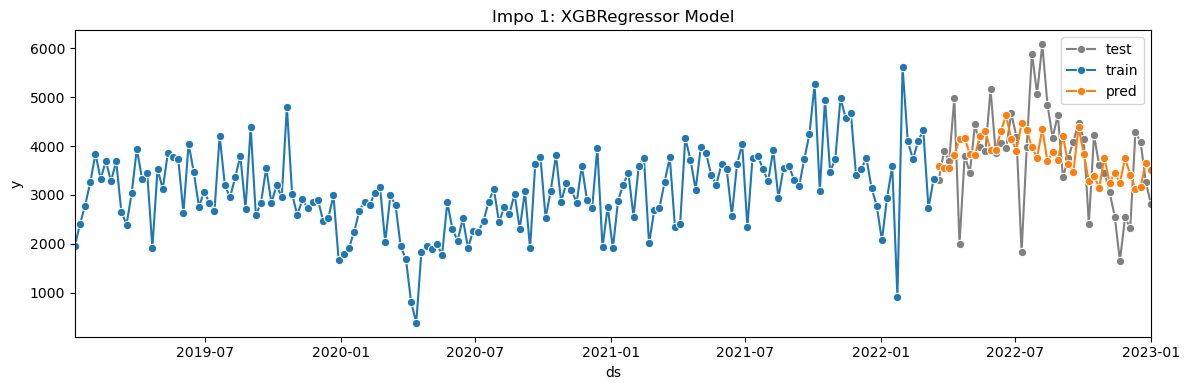

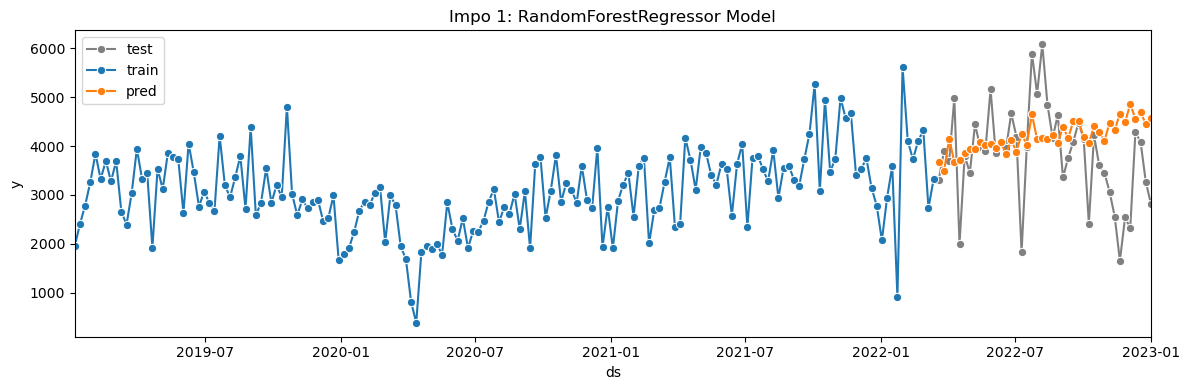

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_14812\3453618423.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['unique_id']= 'id_00'
C:\Users\Bravo15\AppData\Local\Temp\ipykernel_14812\3453618423.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['unique_id']=  'id_00'
C:\Users\Bravo15\AppData\Local\Temp\ipykernel_14812\3453618423.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


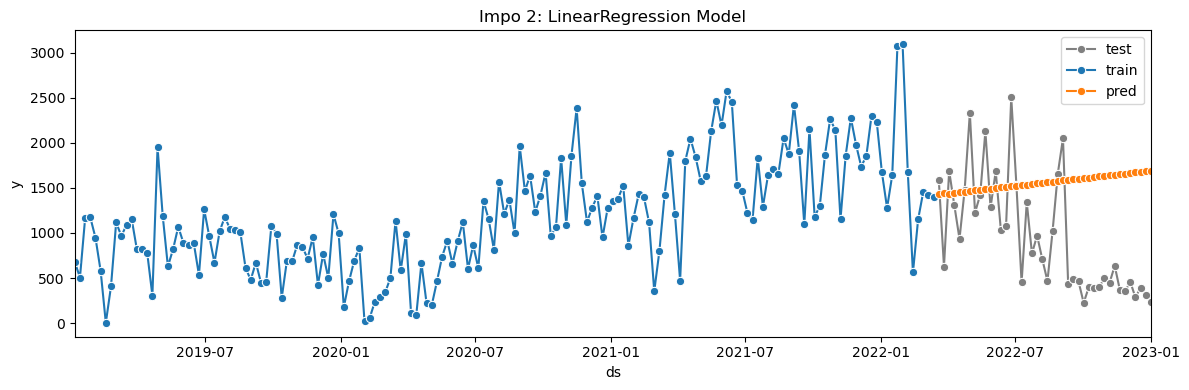

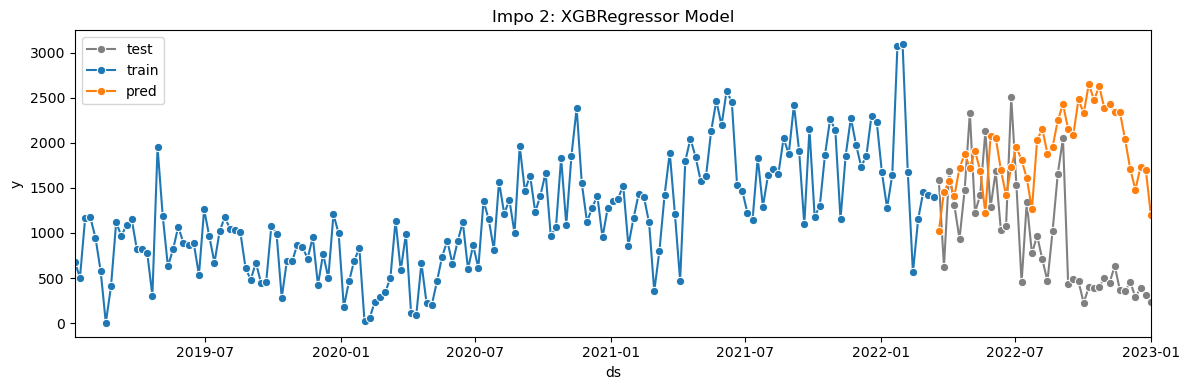

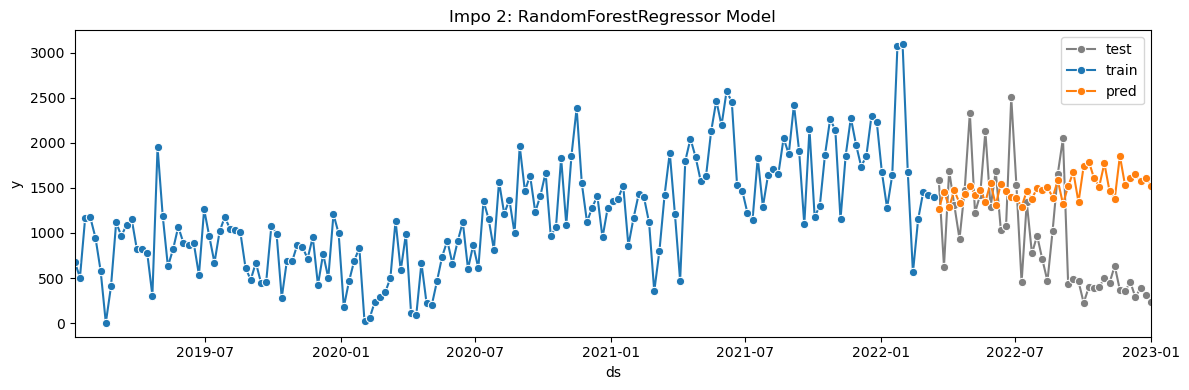

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_14812\3453618423.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['unique_id']= 'id_00'
C:\Users\Bravo15\AppData\Local\Temp\ipykernel_14812\3453618423.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['unique_id']=  'id_00'
C:\Users\Bravo15\AppData\Local\Temp\ipykernel_14812\3453618423.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


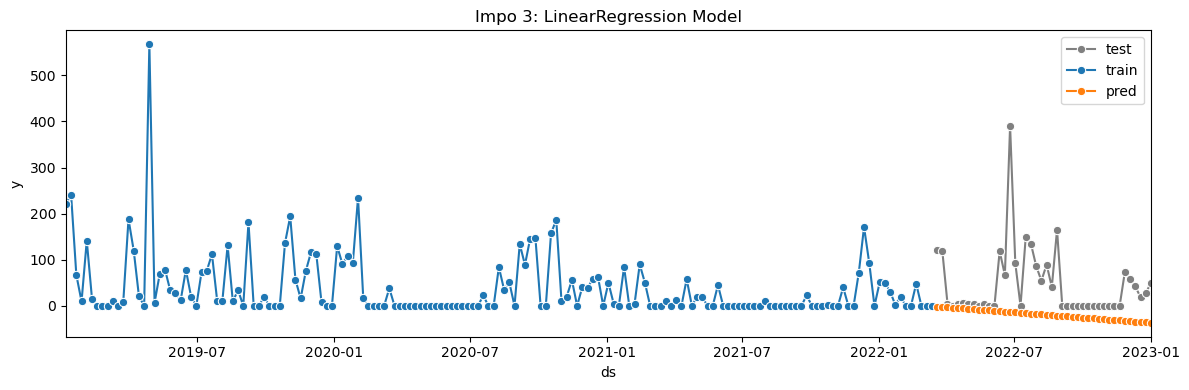

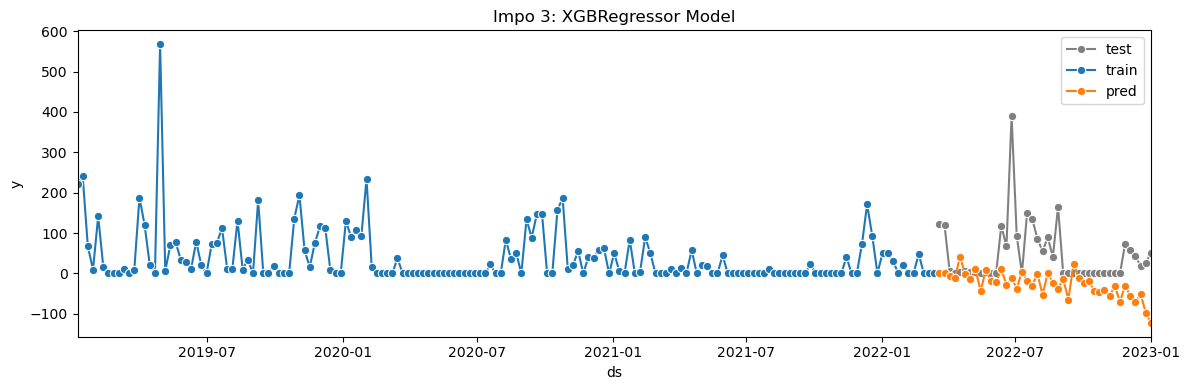

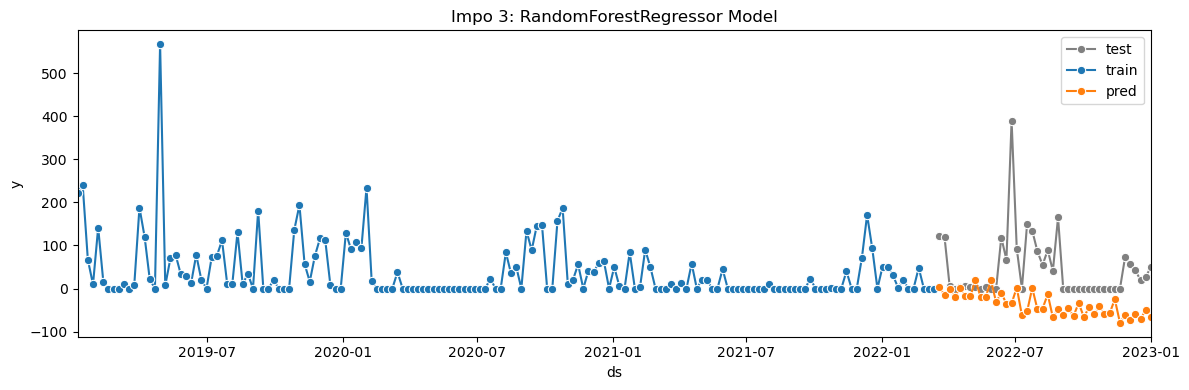

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_14812\3453618423.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['unique_id']= 'id_00'
C:\Users\Bravo15\AppData\Local\Temp\ipykernel_14812\3453618423.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['unique_id']=  'id_00'
C:\Users\Bravo15\AppData\Local\Temp\ipykernel_14812\3453618423.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


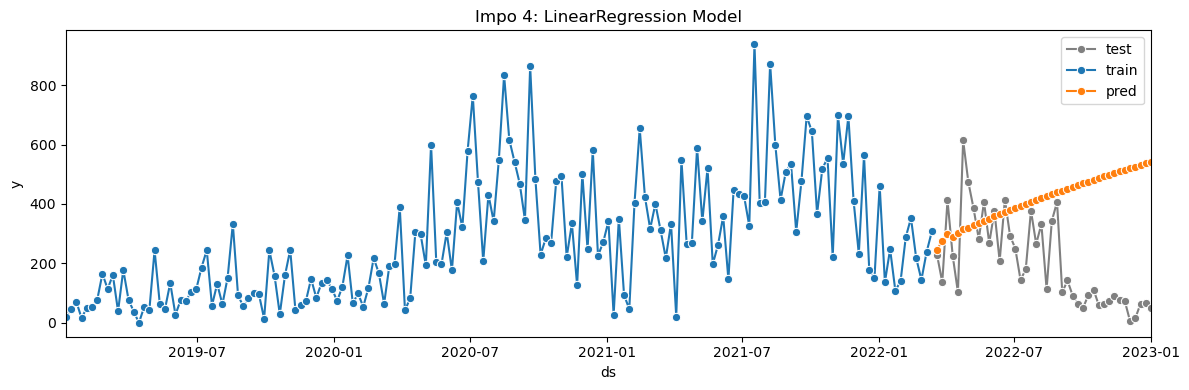

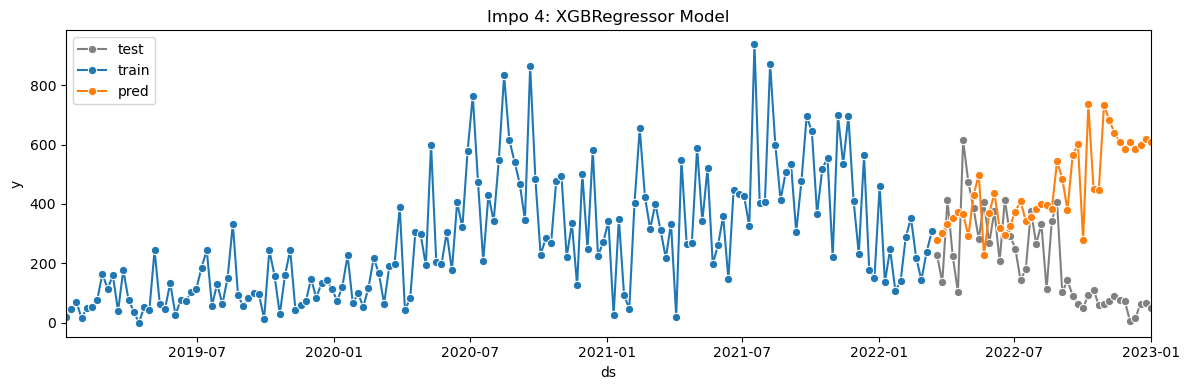

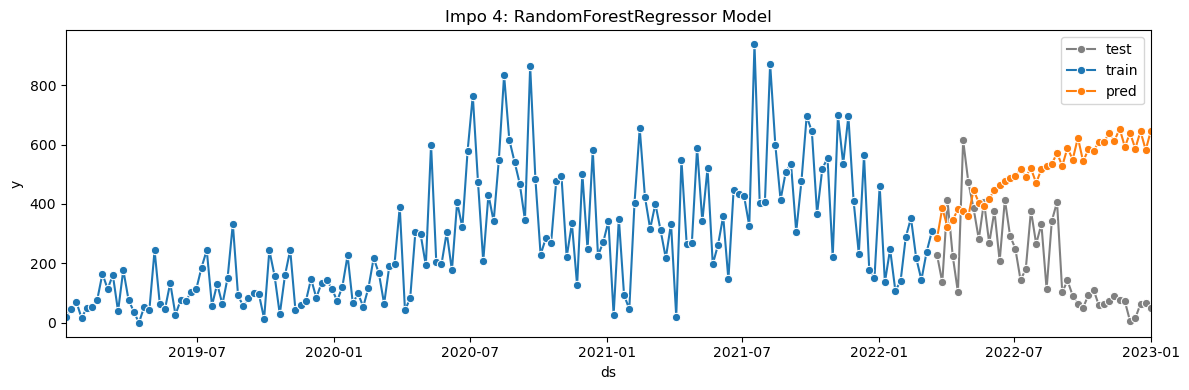

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_14812\3453618423.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['unique_id']= 'id_00'
C:\Users\Bravo15\AppData\Local\Temp\ipykernel_14812\3453618423.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['unique_id']=  'id_00'
C:\Users\Bravo15\AppData\Local\Temp\ipykernel_14812\3453618423.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


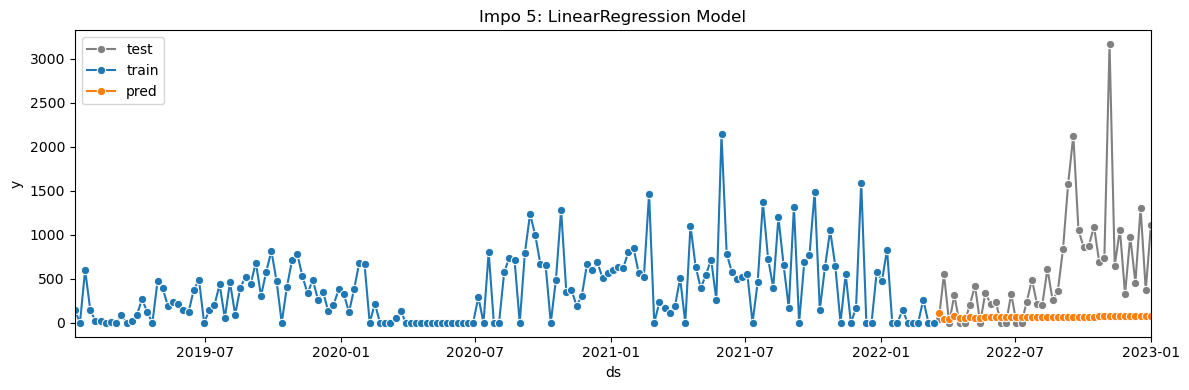

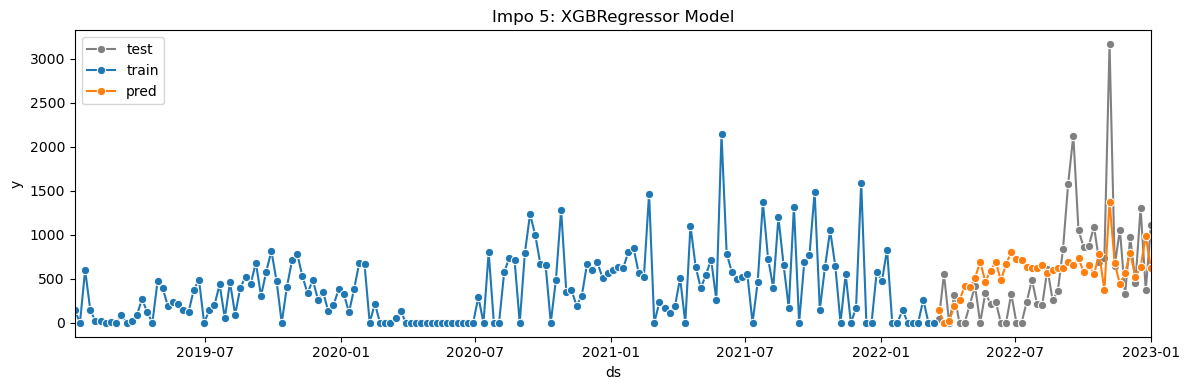

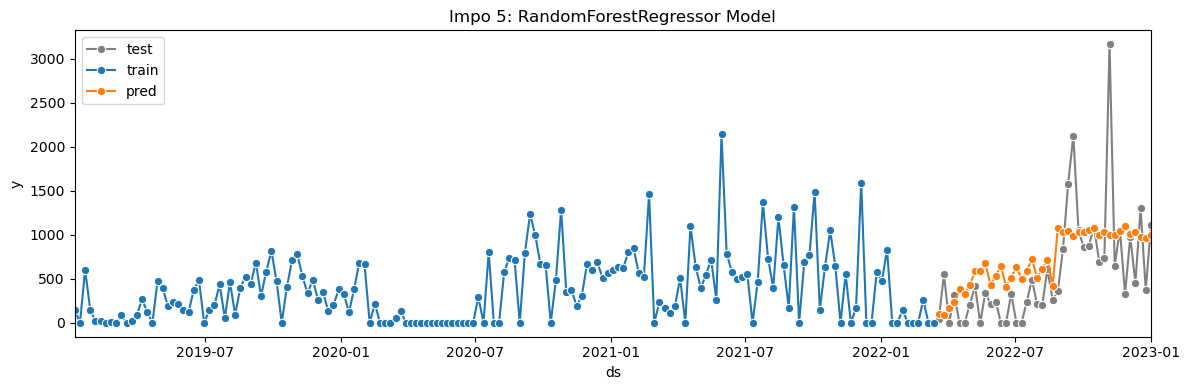

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_14812\3453618423.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['unique_id']= 'id_00'
C:\Users\Bravo15\AppData\Local\Temp\ipykernel_14812\3453618423.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['unique_id']=  'id_00'
C:\Users\Bravo15\AppData\Local\Temp\ipykernel_14812\3453618423.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


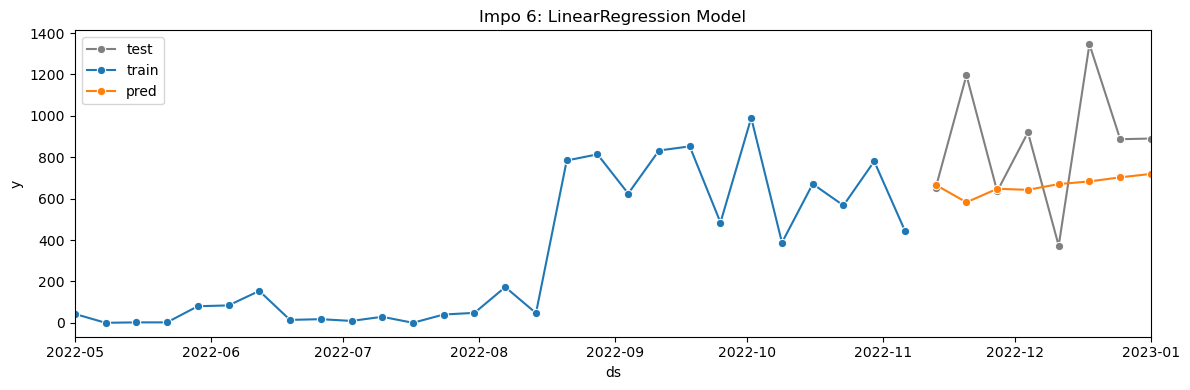

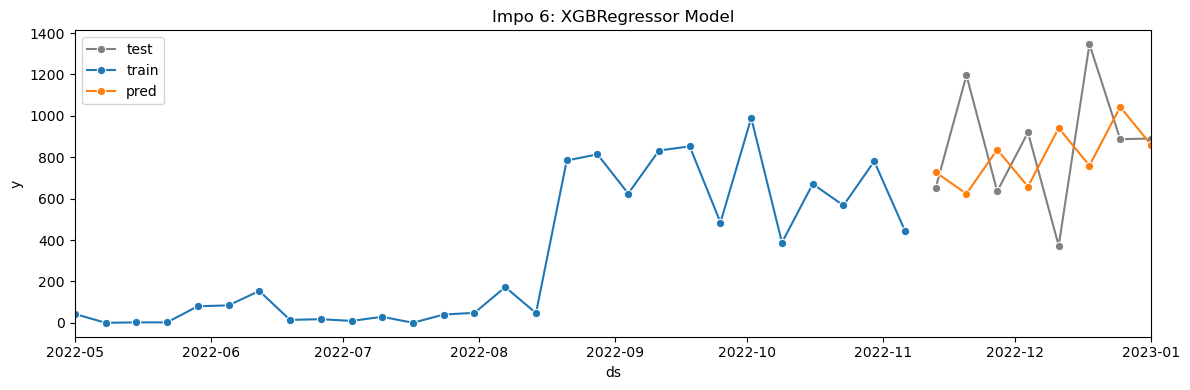

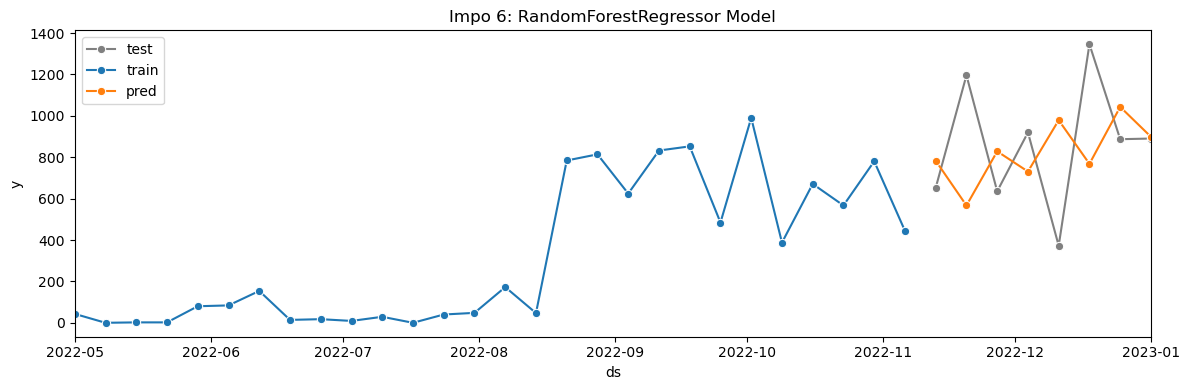

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_14812\3453618423.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['unique_id']= 'id_00'
C:\Users\Bravo15\AppData\Local\Temp\ipykernel_14812\3453618423.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['unique_id']=  'id_00'
C:\Users\Bravo15\AppData\Local\Temp\ipykernel_14812\3453618423.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


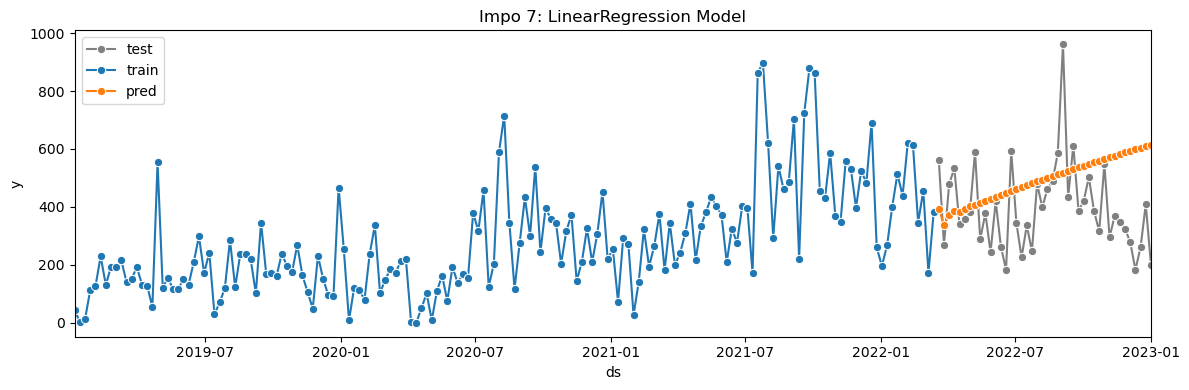

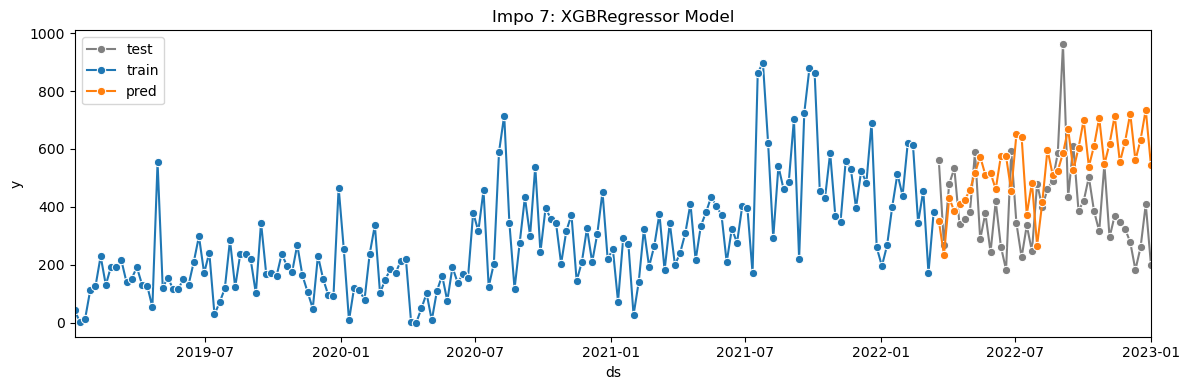

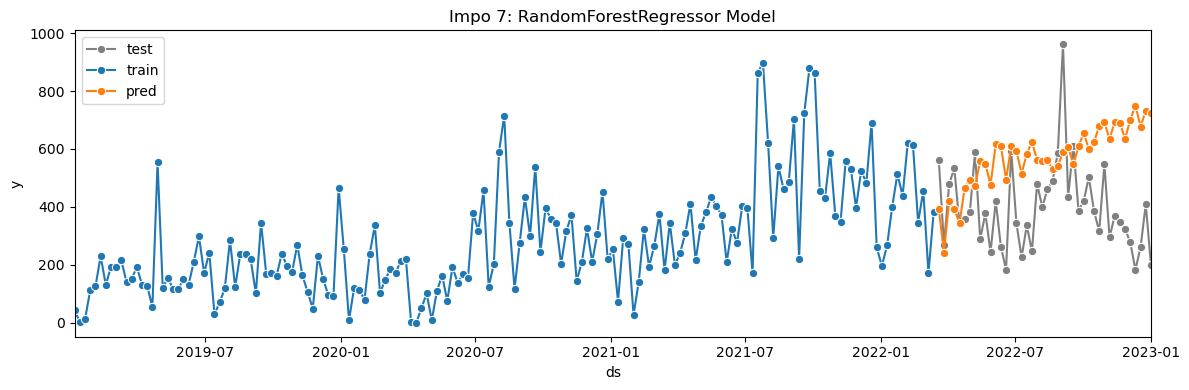

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_14812\3453618423.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['unique_id']= 'id_00'
C:\Users\Bravo15\AppData\Local\Temp\ipykernel_14812\3453618423.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['unique_id']=  'id_00'
C:\Users\Bravo15\AppData\Local\Temp\ipykernel_14812\3453618423.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


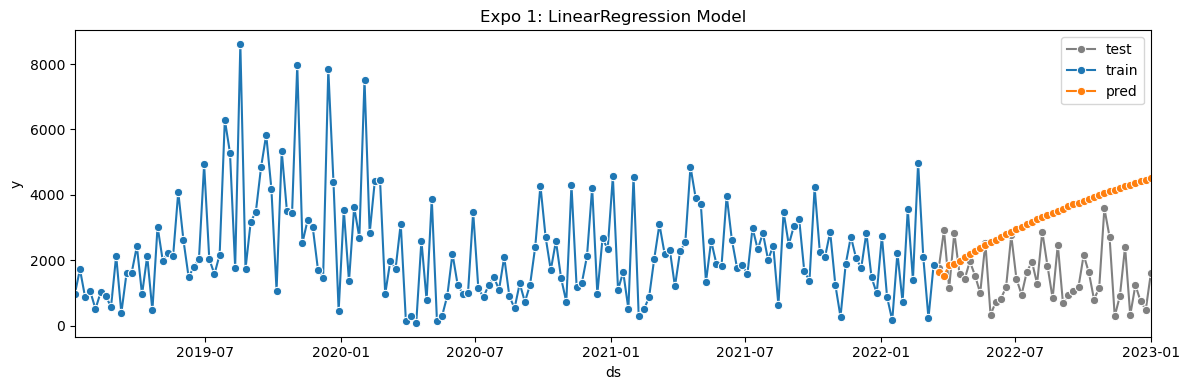

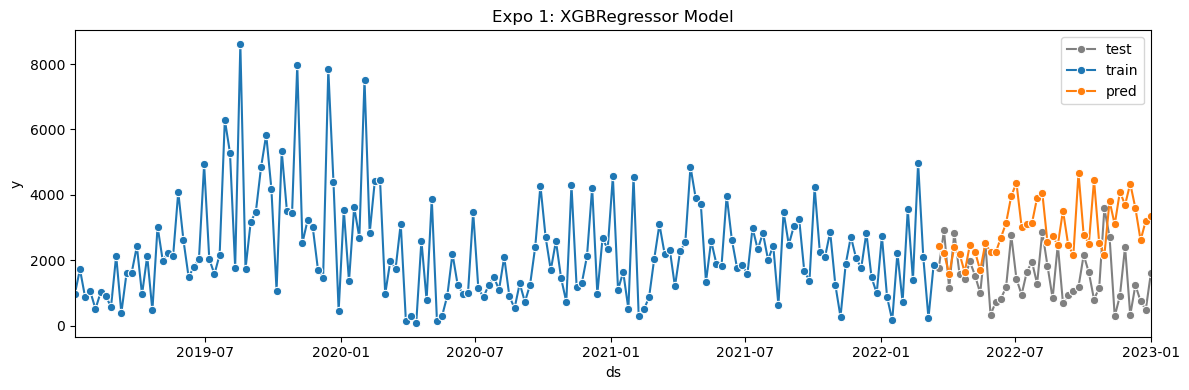

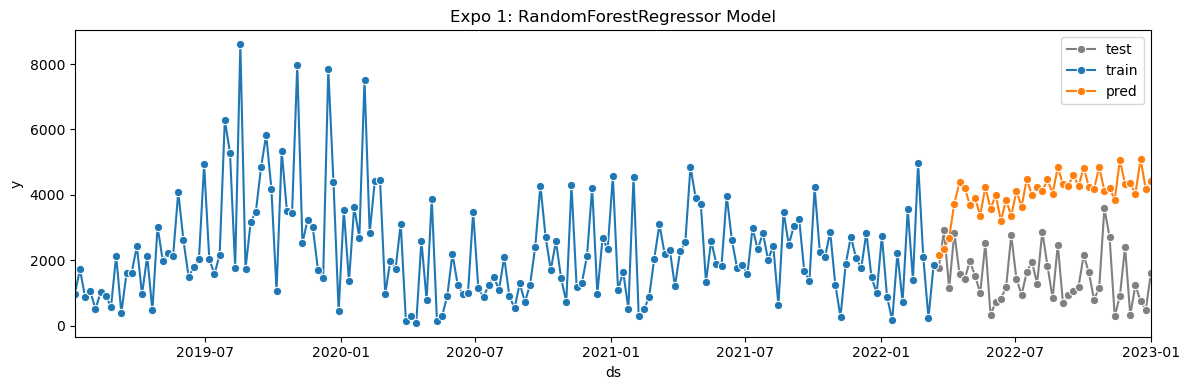

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_14812\3453618423.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['unique_id']= 'id_00'
C:\Users\Bravo15\AppData\Local\Temp\ipykernel_14812\3453618423.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['unique_id']=  'id_00'
C:\Users\Bravo15\AppData\Local\Temp\ipykernel_14812\3453618423.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


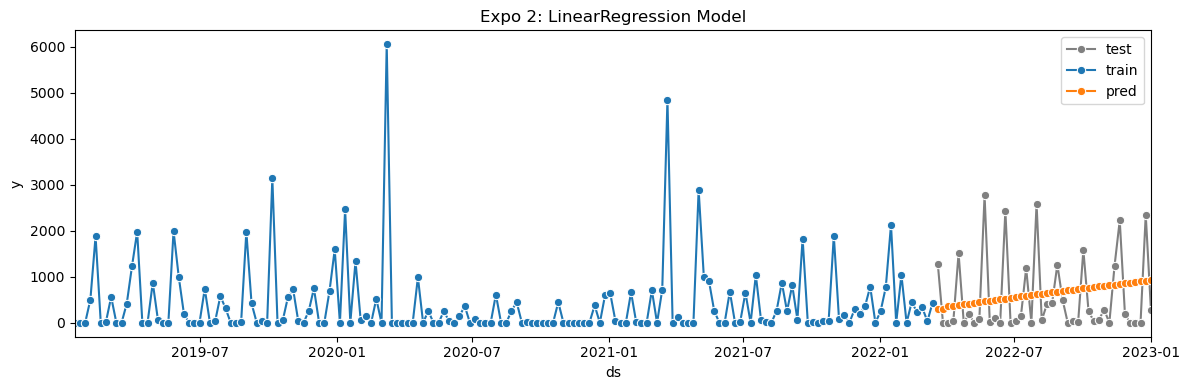

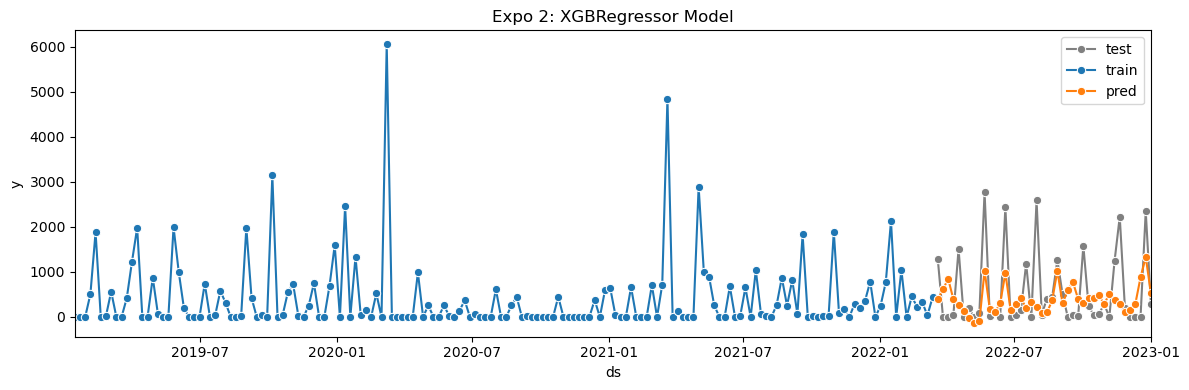

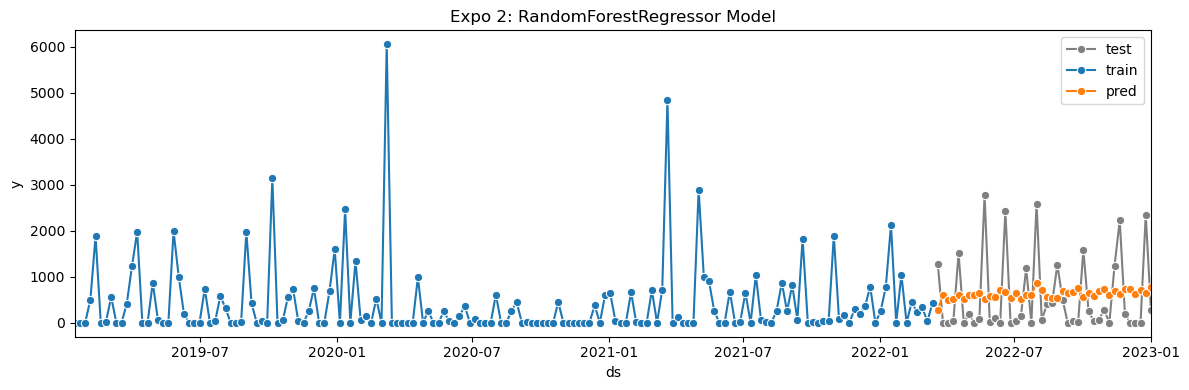

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_14812\3453618423.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['unique_id']= 'id_00'
C:\Users\Bravo15\AppData\Local\Temp\ipykernel_14812\3453618423.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['unique_id']=  'id_00'
C:\Users\Bravo15\AppData\Local\Temp\ipykernel_14812\3453618423.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


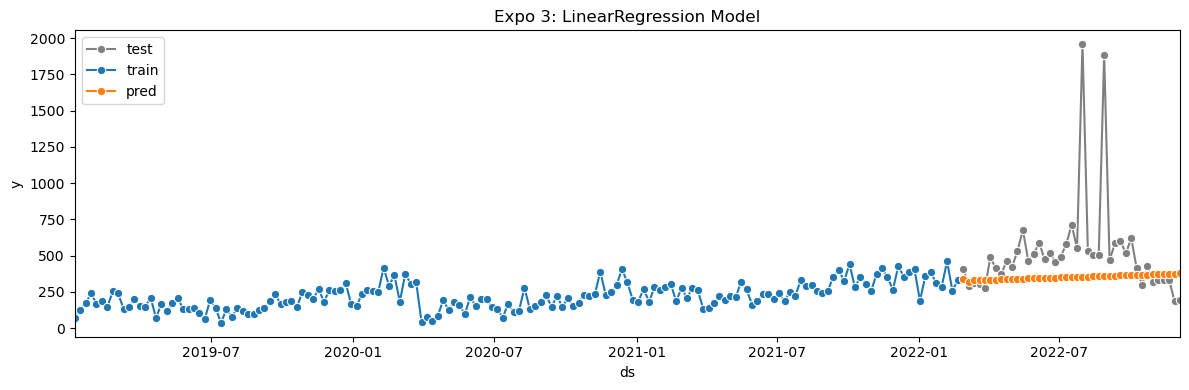

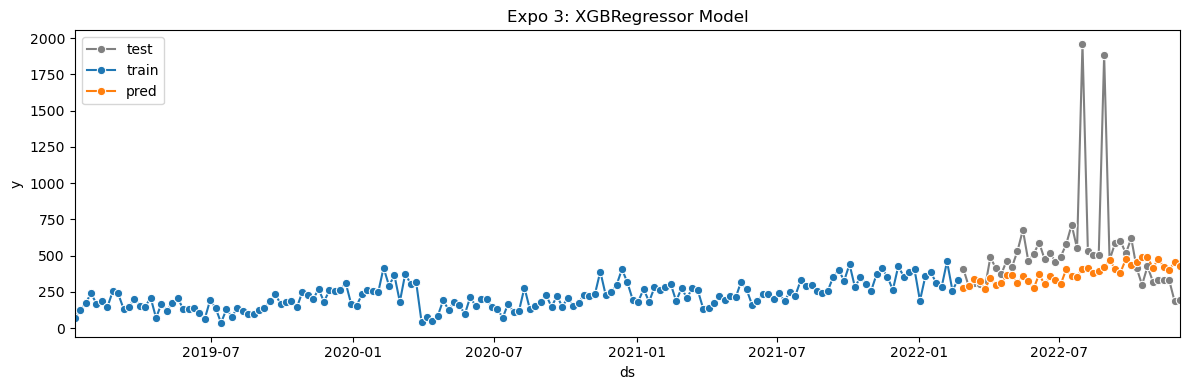

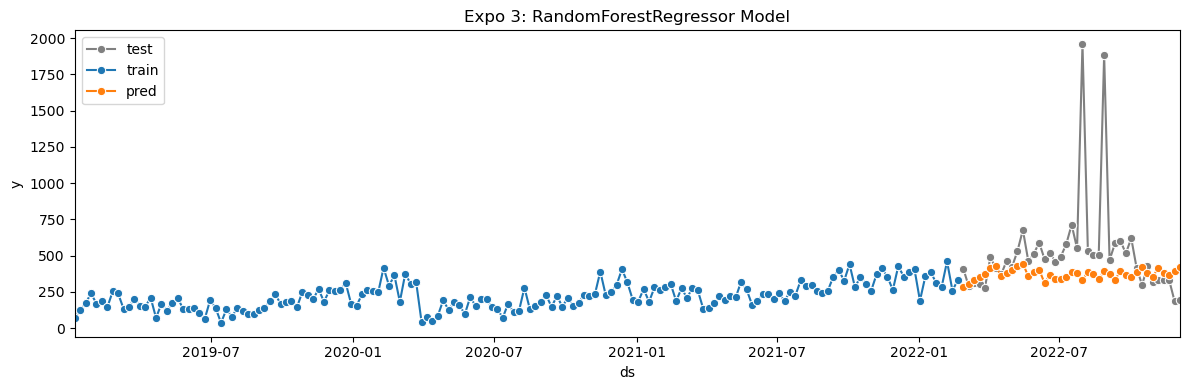

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_14812\3453618423.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['unique_id']= 'id_00'
C:\Users\Bravo15\AppData\Local\Temp\ipykernel_14812\3453618423.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['unique_id']=  'id_00'
C:\Users\Bravo15\AppData\Local\Temp\ipykernel_14812\3453618423.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


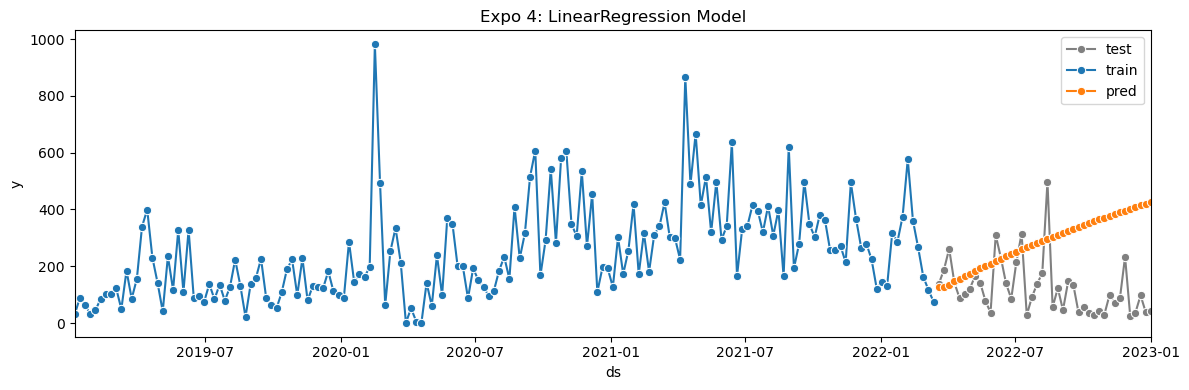

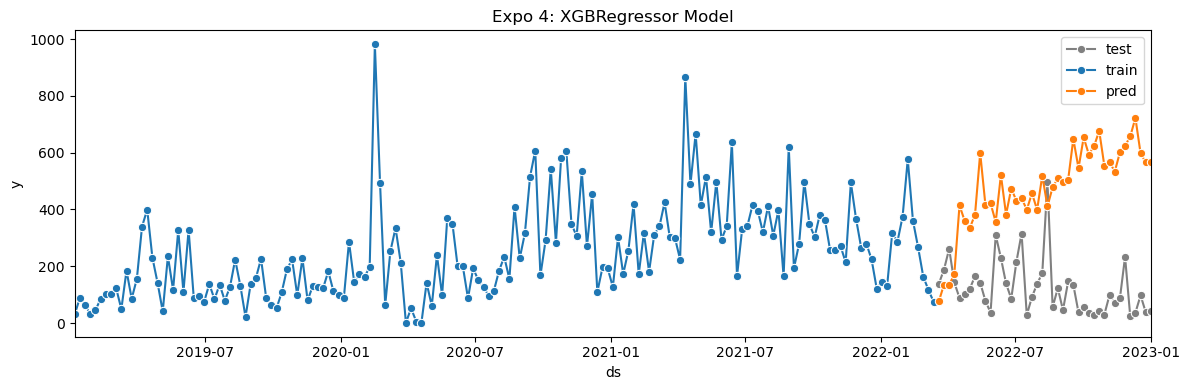

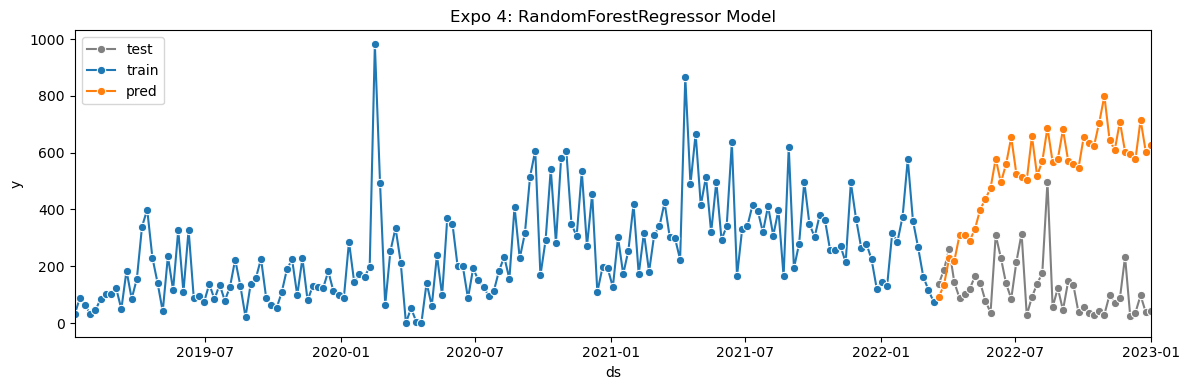

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_14812\3453618423.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['unique_id']= 'id_00'
C:\Users\Bravo15\AppData\Local\Temp\ipykernel_14812\3453618423.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['unique_id']=  'id_00'
C:\Users\Bravo15\AppData\Local\Temp\ipykernel_14812\3453618423.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


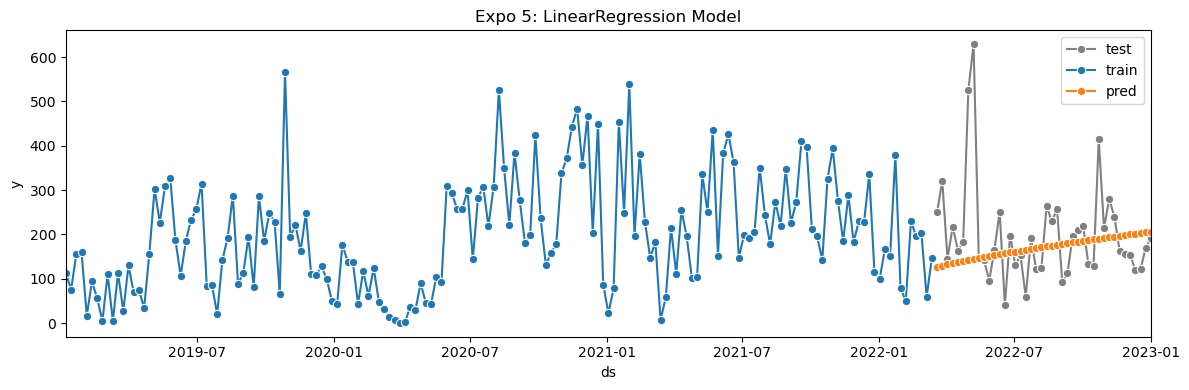

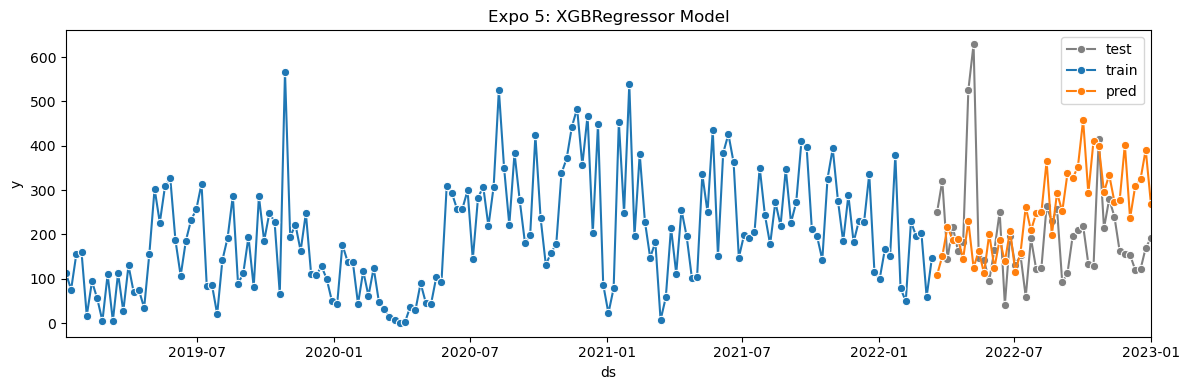

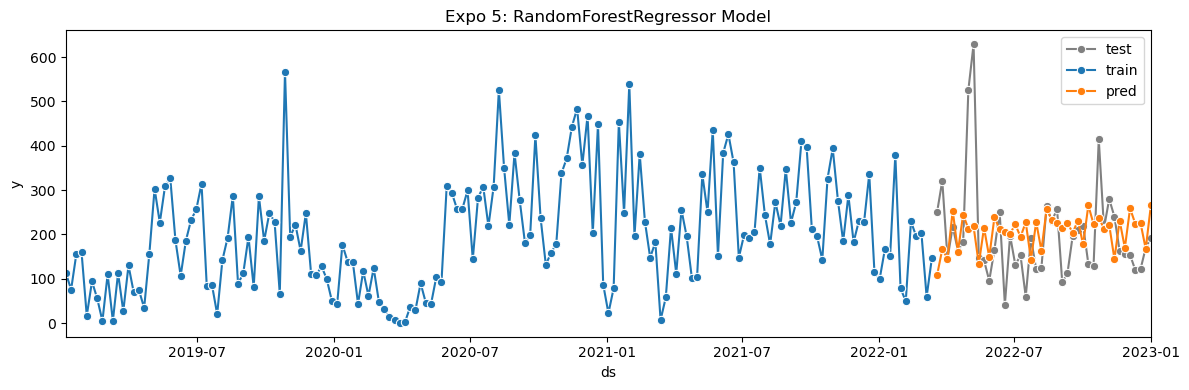

In [35]:
comparison_tbl= ml_model(models, df_impo_1, 'Impo 1', comparison_tbl)
comparison_tbl= ml_model(models, df_impo_2, 'Impo 2', comparison_tbl)
comparison_tbl= ml_model(models, df_impo_3, 'Impo 3', comparison_tbl)
comparison_tbl= ml_model(models, df_impo_4, 'Impo 4', comparison_tbl)
comparison_tbl= ml_model(models, df_impo_5, 'Impo 5', comparison_tbl)
comparison_tbl= ml_model(models, df_impo_6, 'Impo 6', comparison_tbl)
comparison_tbl= ml_model(models, df_impo_7, 'Impo 7', comparison_tbl)
comparison_tbl= ml_model(models, df_expo_1, 'Expo 1', comparison_tbl)
comparison_tbl= ml_model(models, df_expo_2, 'Expo 2', comparison_tbl)
comparison_tbl= ml_model(models, df_expo_3, 'Expo 3', comparison_tbl)
comparison_tbl= ml_model(models, df_expo_4, 'Expo 4', comparison_tbl)
comparison_tbl= ml_model(models, df_expo_5, 'Expo 5', comparison_tbl)

In [36]:
best_models = comparison_tbl.groupby('Serie').apply(lambda group: group[group['RMSE'] == group['RMSE'].min()])
best_models.drop(columns='Serie', inplace=True)
best_models = best_models.groupby('Serie').first().reset_index()
best_models_sorted = best_models.sort_values(by='RMSE', ascending=True)
best_models_sorted.head(12)

Serie                                  Modelo         MAE        RMSE  \
7   Impo 3                SARIMAX ([1, 2], 0, [5])   42.912352   77.237038   
22  impo_6  Nixtla Conjunto: RandomForestRegressor   94.841868  110.519119   
4   Expo 5                   RandomForestRegressor   81.379917  115.123624   
3   Expo 4                SARIMAX ([1, 2], 1, [2])   96.732396  137.010334   
11  Impo 7               SARIMAX ([1, 2], 0, [10])  141.687432  183.721246   
8   Impo 4                   SARIMAX ([2], 0, [1])  185.779630  213.952750   
10  Impo 6                        LinearRegression  279.146925  361.462184   
2   Expo 3                   SARIMAX ([3], 0, [1])  199.795894  367.519378   
20  impo_4           Nixtla Conjunto: XGBRegressor  434.523882  441.444018   
15  expo_4           Nixtla Conjunto: XGBRegressor  463.871322  465.450606   
16  expo_5           Nixtla Conjunto: XGBRegressor  464.379832  473.760021   
23  impo_7  Nixtla Conjunto: RandomForestRegressor  475.374047  480.642438   

       sMAPE  Processing Time  
7   1.431710           3.6963  
22  1.992018           4.5768  
4   0.395216           2.6867  
3   0.726832           2.5775  
11  0.342107          13.6703  
8   0.812257           1.3832  
10  0.344264           0.7679  
2   0.367942           5.9424  
20  1.999860           4.5768  
15  1.999926           4.5768  
16  1.999802           4.5768  
23  1.999585           4.5768

Es evidente que estos primeros resultados no son los esperados, y decepciona ver como modelos estadisticos clasicos con un buen tuneo de hiperparametros logran mejor performance que modelos de ML. Sin embargo, no sorprenden los resultados ya que las series poseen comportamientos particulares y erráticos como se observo en las primeras secciones del análisis, esto provoca que el modelado de las series sea más complejo por lo que en las siguientes secciones intentaré mejorar las perfomance de los modelos a través de distintas herramientas.

#### 2.1.2 ML Nixtla - Entrenamiento conjunto

En esta sección, correré los mismos modelos pero al utilizar la libreria Nixtla me permite entrenar los modelos para todas las series en conjunto, asi logro que el modelo capture patrones de todos los motivos pudiendo aplicar insights cruzados entre si, ya que recordemos que las series representan los motivos y rutas pero tienen factores en comun como: la situacion economica de Argentina en ese momento del tiempo, el tipo de cambio, la disposicion a pagar de los clientes, las condiciones economicas internacionales, etc.  Por ello, factores que afecten a una serie probablemente afecten a las demas, de esta forma se pueden tener insights cruzados entre ellas permitiendo una mejor performance del modelo. 

Creamos el dataset unificado donde con la columan unique_id diferenciare las series entre si

In [37]:
df_unificado= DataPrep().unificar_df()

In [38]:
df_unificado.head()

ds unique_id       y
0  2019-01-06    impo_1  1950.0
1  2019-01-13    impo_1  2402.0
2  2019-01-20    impo_1  2782.0
3  2019-01-27    impo_1  3263.0
4  2019-02-03    impo_1  3843.0

__Funciones útiles: ML Nixtla Entrenamiento Conjunto__

In [39]:
def modelado_nixtla_conjunto(models, df_unificado, comparison_tbl): 
    
    """Permite modelar varios modelos de ML a la vez, entrenando todas las series juntas diferenciandola por el unique_id"""
    
    df_unificado[['ds']]= pd.to_datetime(df_unificado['ds'], format='%Y-%m-%d')
    
    tic = time.clock()

    fcst = MLForecast(
        models=models,
        freq='W',
        lags=[7, 14],
        lag_transforms={
            1: [expanding_mean]},
        target_transforms=[Differences([1])],
    )
    
    #separamos en train y test 
    #para lograr comparar todos los modelos entre si, elegi un periodo de 20 semanas para testear todos, evaluando cumple
    #en la mayoria de los casos con una proporcion razonable entre train y test
    unique_ids = df_unificado['unique_id'].unique() 
    
    #escalo los datos para que los modelos puedan captar informacion entre si, ya que si no escalo no logran realizar el entrenamiento cruzado que se busca
    min_max_scaler = preprocessing.MinMaxScaler()
    df_unificado[['y']]=min_max_scaler.fit_transform(df_unificado[['y']])

    # Crear listas para almacenar los DataFrames de train y test
    train_dfs = []
    test_dfs = []

    for unique_id in unique_ids:
    
        serie_df = df_unificado[df_unificado['unique_id'] == unique_id]
        test_df = serie_df.iloc[-20:]  # Últimas 20 semanas para el conjunto de prueba
        train_df = serie_df.iloc[:-20]  # Resto para el conjunto de entrenamiento
    
        train_dfs.append(train_df)
        test_dfs.append(test_df)

    # Concatenar los DataFrames de train y test
    df_train = pd.concat(train_dfs)
    df_test = pd.concat(test_dfs)

    #entrenamos el modelo
    fcst.fit(df_train)
    
    #obtenemos un df de predictions con las predicciones para todas las series juntas
    
    predictions = fcst.predict(20) 
    
    print(predictions.columns)
    toc =  time.clock() #frenamos el cronometro y a continuacion creamos la variable que guarda el tiempo transcurrido desde que empezo a correr el modelo hasta q termino
    exetime = '{0:.4f}'.format(toc-tic)
    
    model_names=['LinearRegression', 'XGBRegressor','RandomForestRegressor']

    
    lista_id= []
    lista_model= []
    lista_mae=[]
    lista_rmse=[]
    lista_smape=[]
    lista_exetime=[]

    for unique_id in unique_ids: 
        for model in model_names: 
            
            train_date= df_train[df_train['unique_id']== unique_id]['ds']
            test_date= df_test[df_test['unique_id']==unique_id]['ds']
            predicted_ds= predictions[predictions['unique_id']==unique_id]['ds']
            
            train_values= df_train[df_train['unique_id']== unique_id]['y']
            
            
            actual_values= df_test[df_test['unique_id']==unique_id]['y']
            predicted_values= predictions[predictions['unique_id']== unique_id][model]
         
            mae = mean_absolute_error(actual_values, predicted_values)
            rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
            smape = Metrics(actual_values, predicted_values).calculate_smape()
            
            lista_id.append(unique_id)
            lista_model.append(f'Nixtla Conjunto: {model}')
            lista_mae.append(mae)
            lista_rmse.append(rmse)
            lista_smape.append(smape)
            lista_exetime.append(exetime)
            
            #graficamos los resultados
            f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
            sns.lineplot(x=test_date, y=actual_values, marker='o', label='test', color='grey')
            sns.lineplot(x=train_date, y=train_values, marker='o', label='train')
            sns.lineplot(x=predicted_ds, y=predicted_values, marker='o', label='pred', color ='orange')
            ax.set_title(f'{unique_id}: Nixtla Conjunto {model}')
            plt.tight_layout()
            plt.show()
    
    
    raw_data = {'Serie': lista_id,
                'Modelo': lista_model,
                'MAE':  lista_mae,
                'RMSE': lista_rmse,
                'sMAPE': lista_smape, 
                'Processing Time': lista_exetime}
    
    df_tbl = pd.DataFrame(raw_data)

    comparison_tbl = pd.concat([comparison_tbl, df_tbl], ignore_index=True)
    
    return comparison_tbl
    
    

Corremos el modelo conjunto 

Index(['unique_id', 'ds', 'LinearRegression', 'XGBRegressor',
       'RandomForestRegressor'],
      dtype='object')


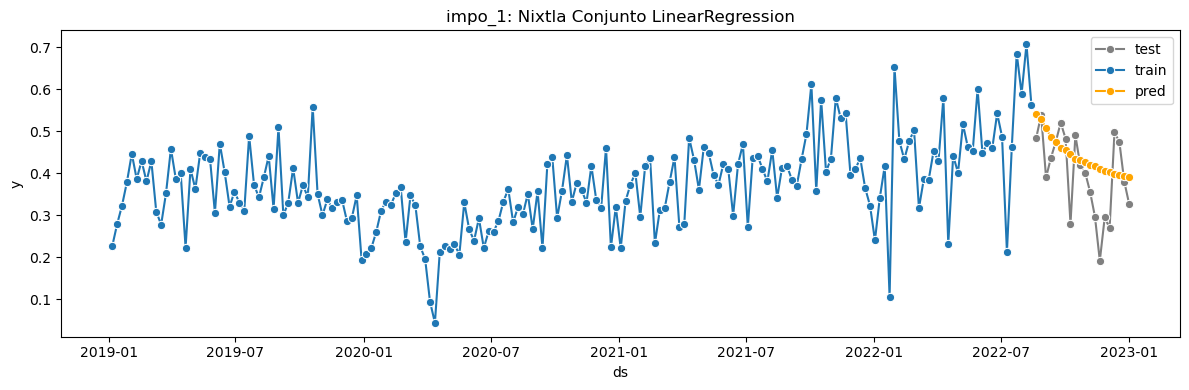

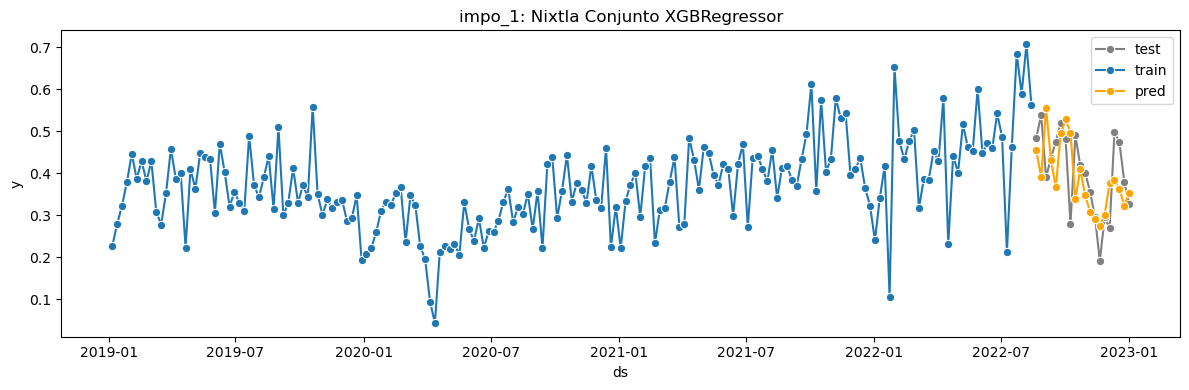

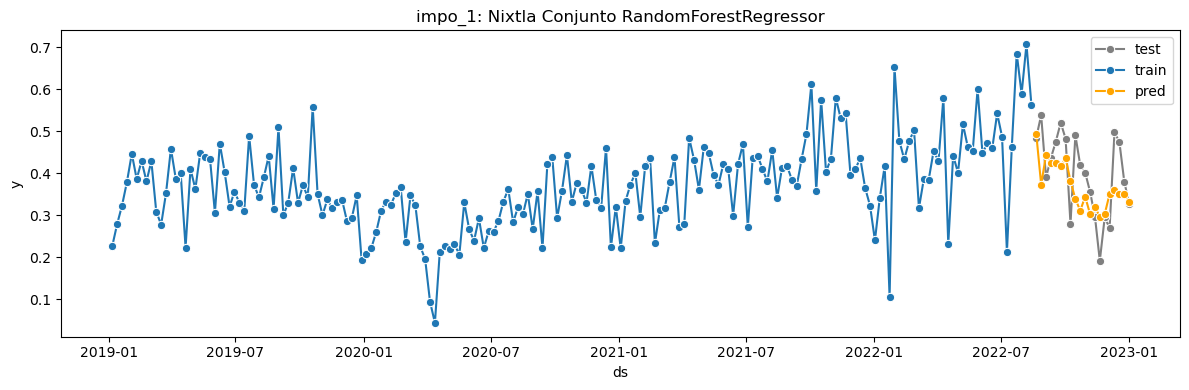

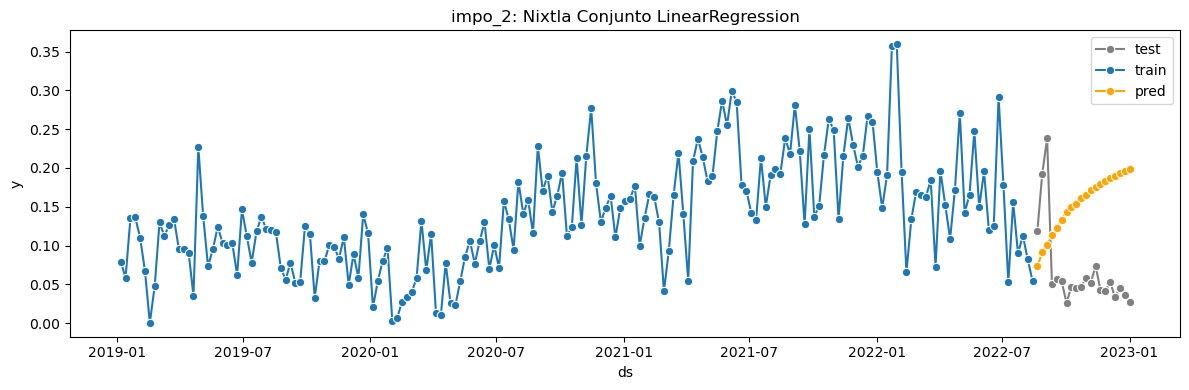

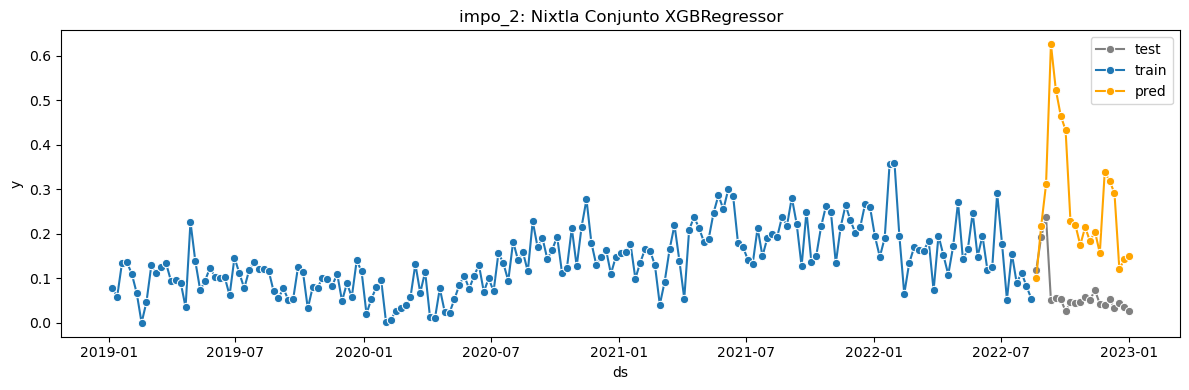

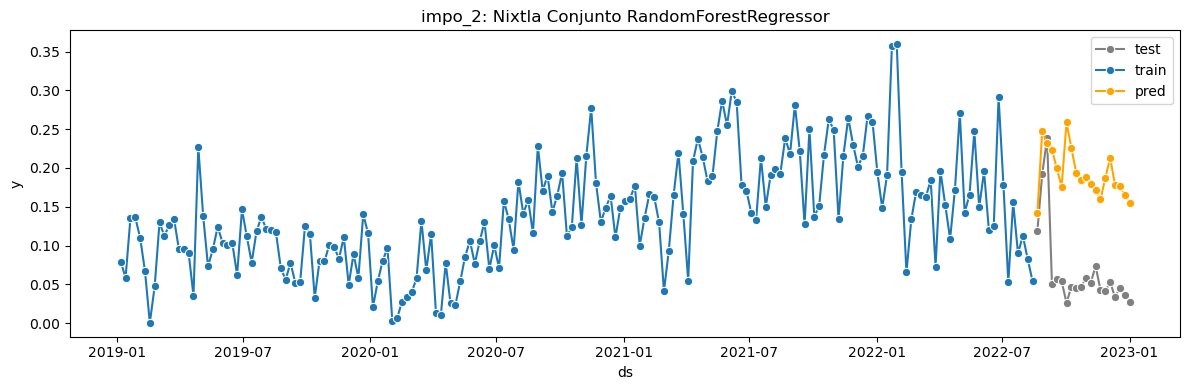

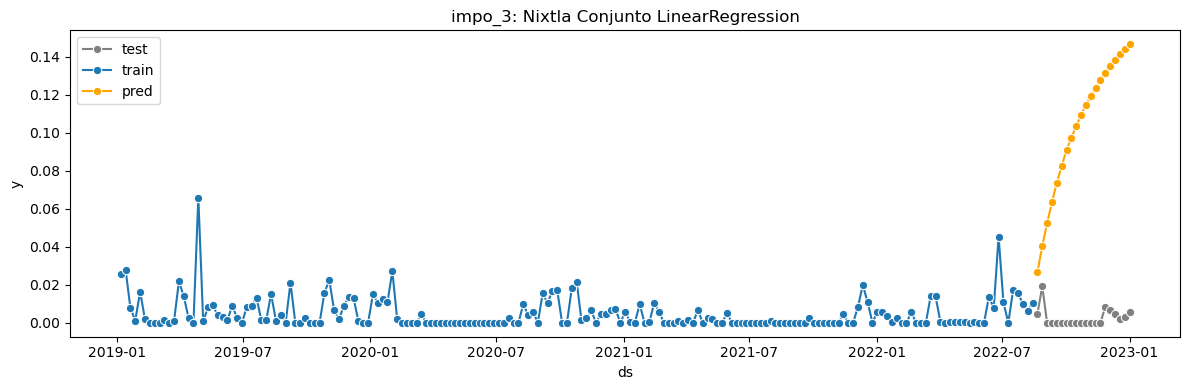

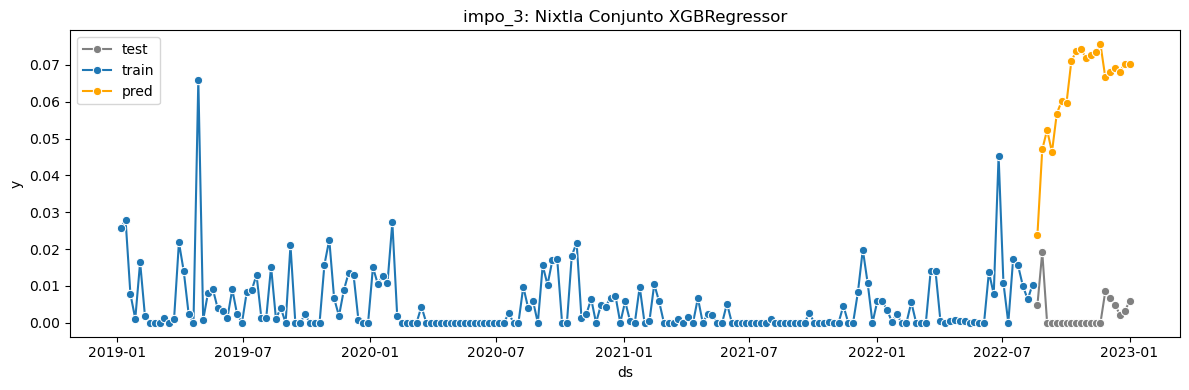

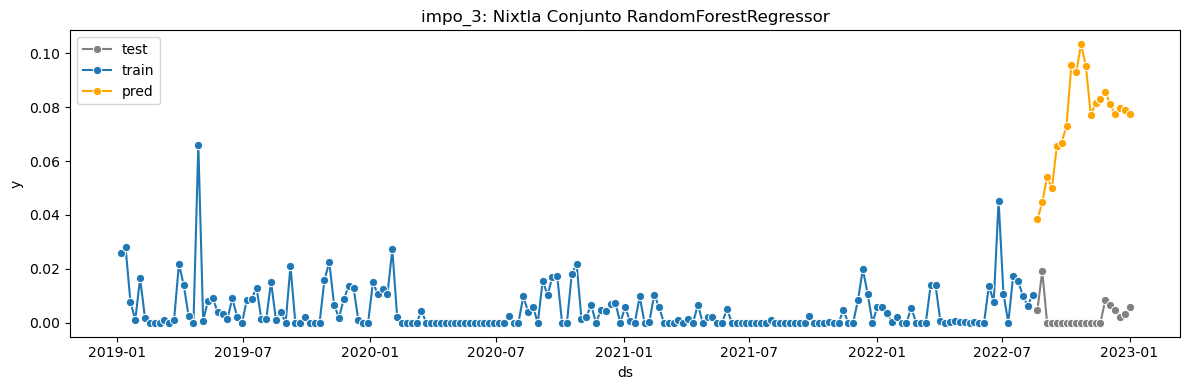

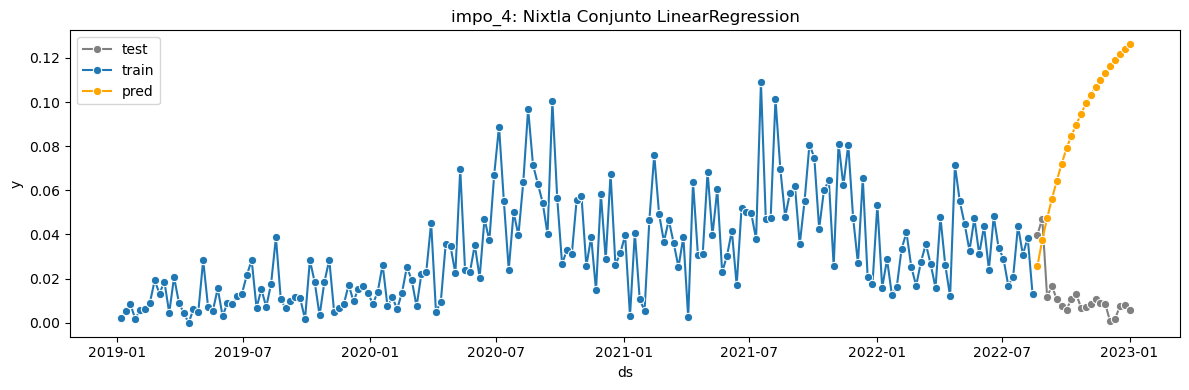

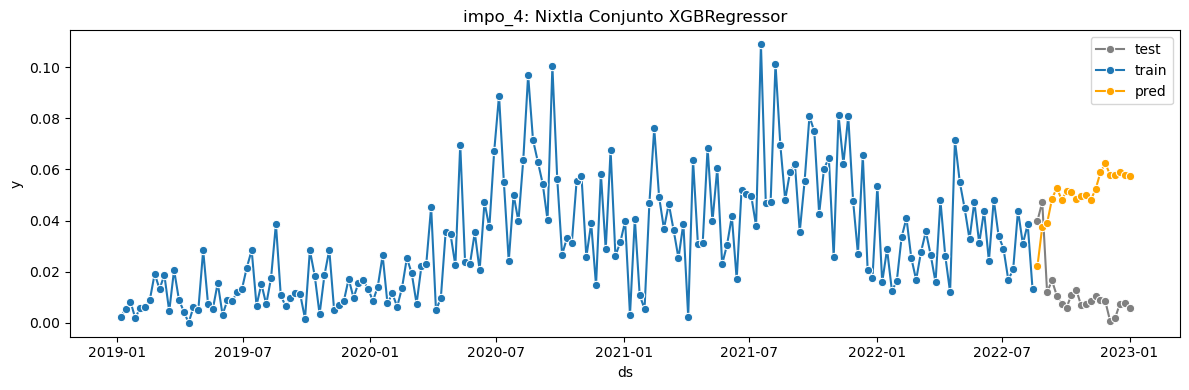

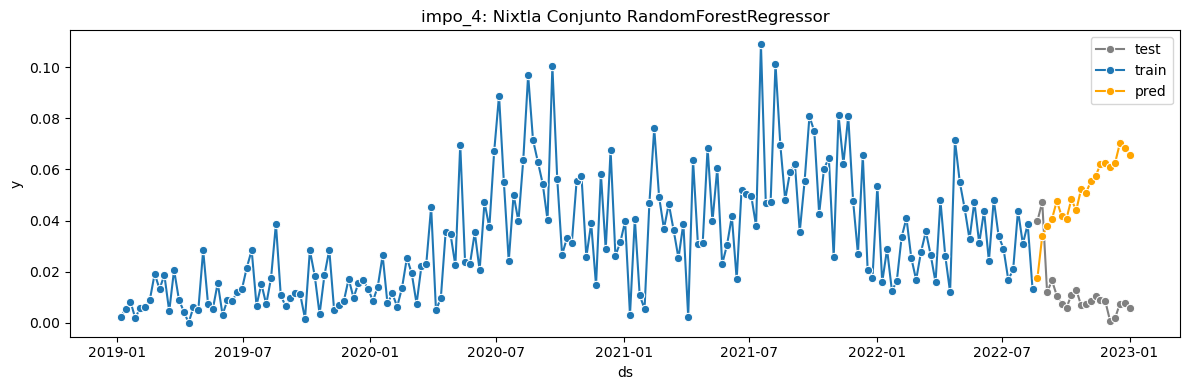

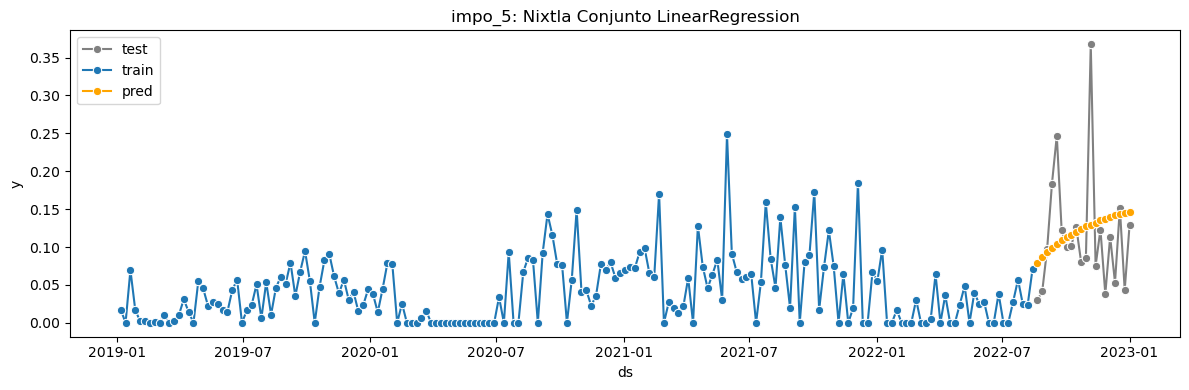

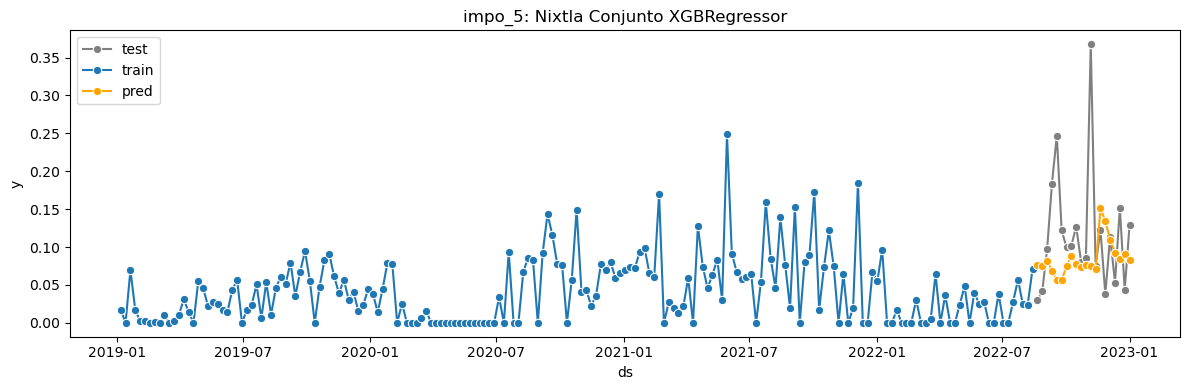

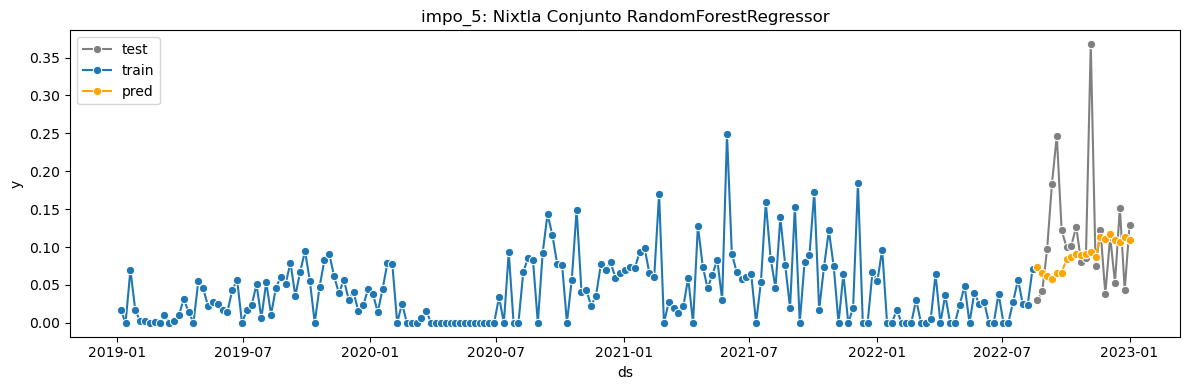

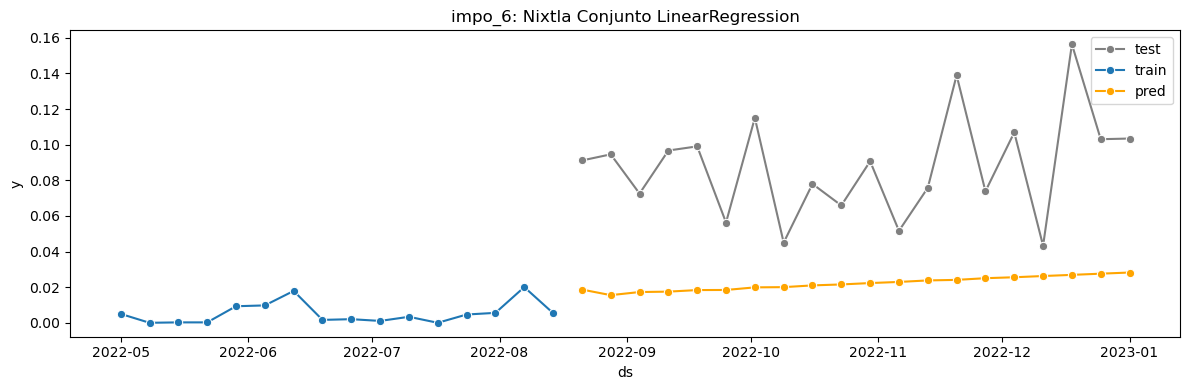

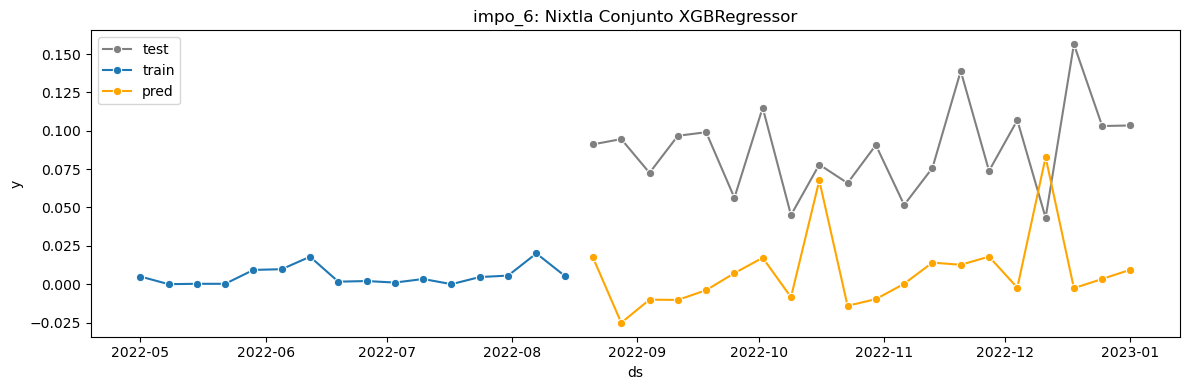

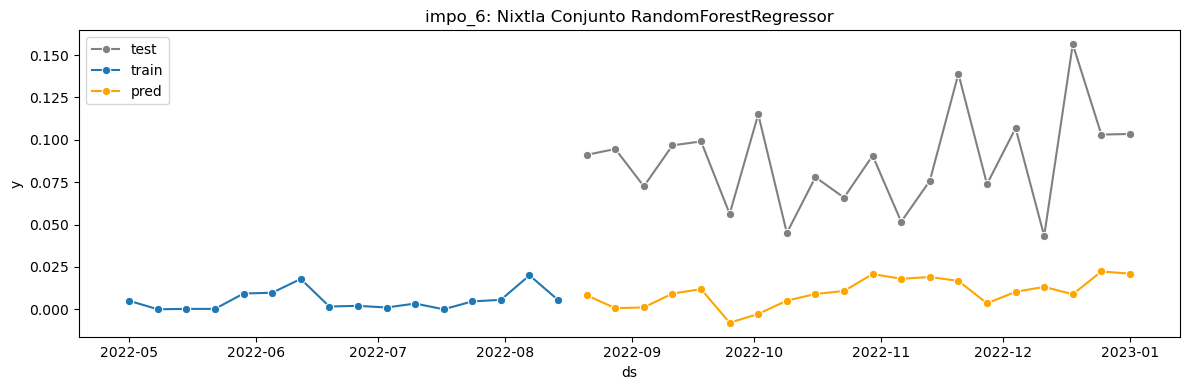

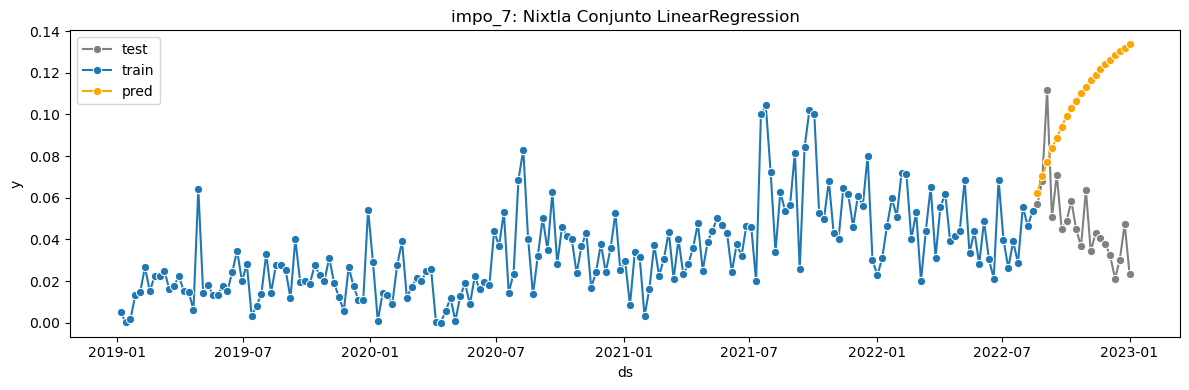

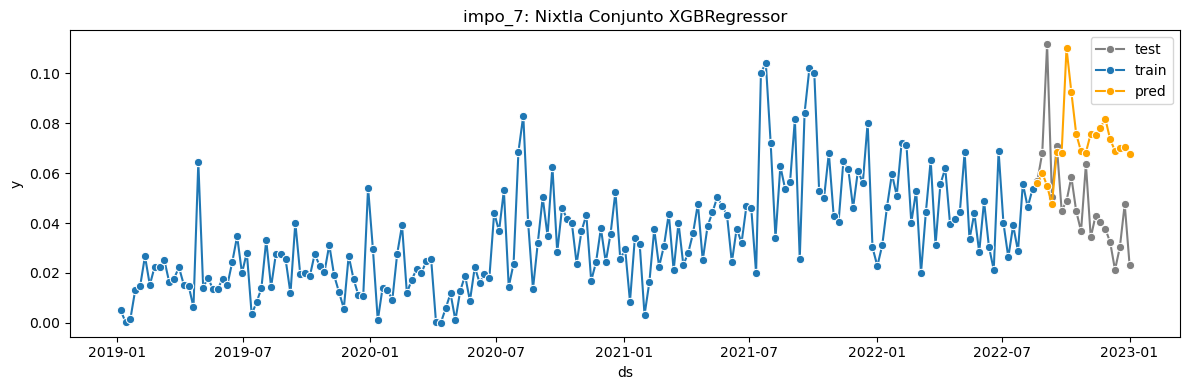

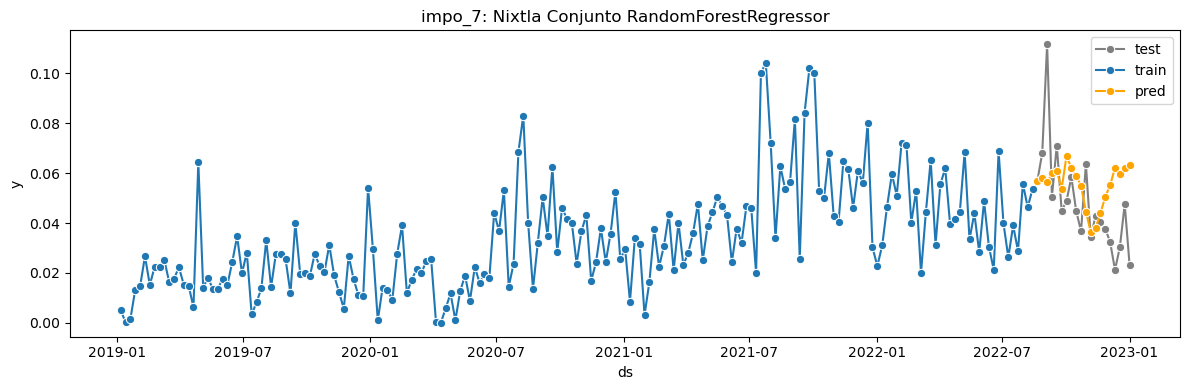

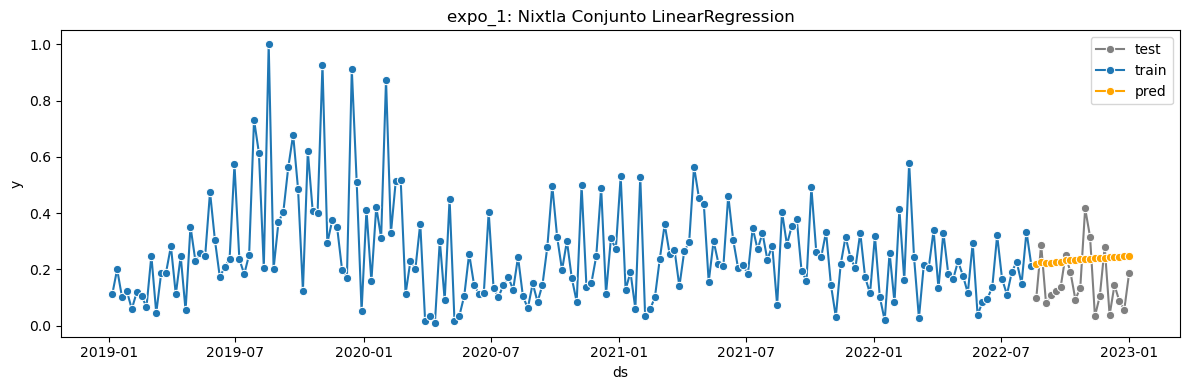

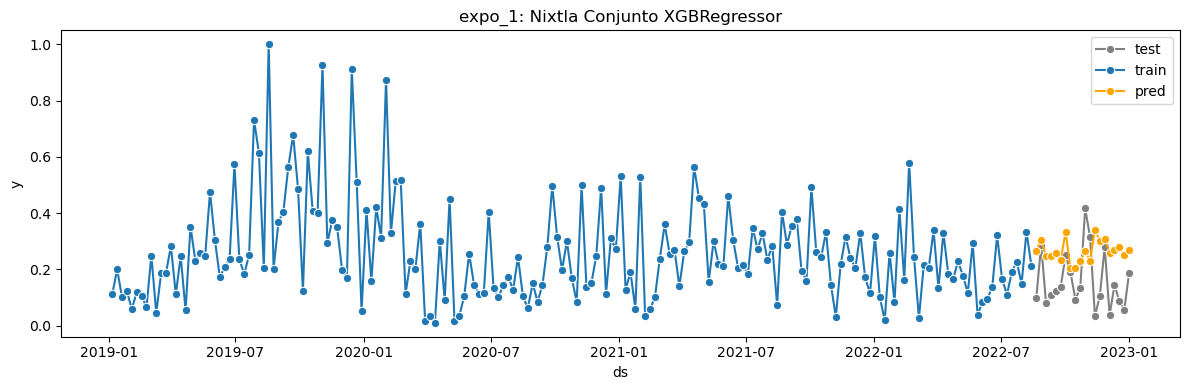

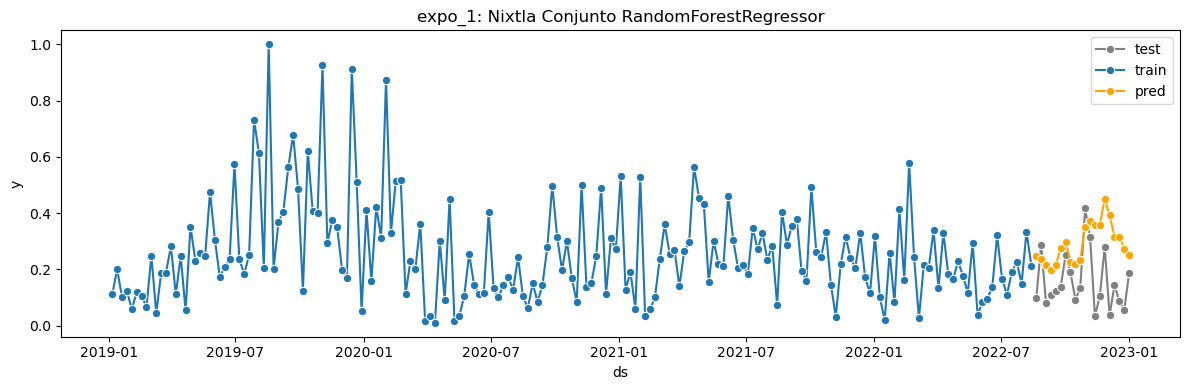

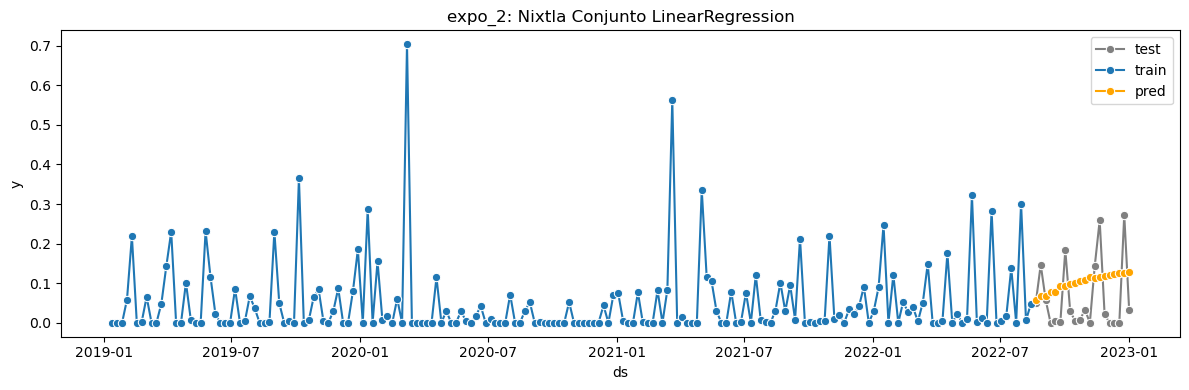

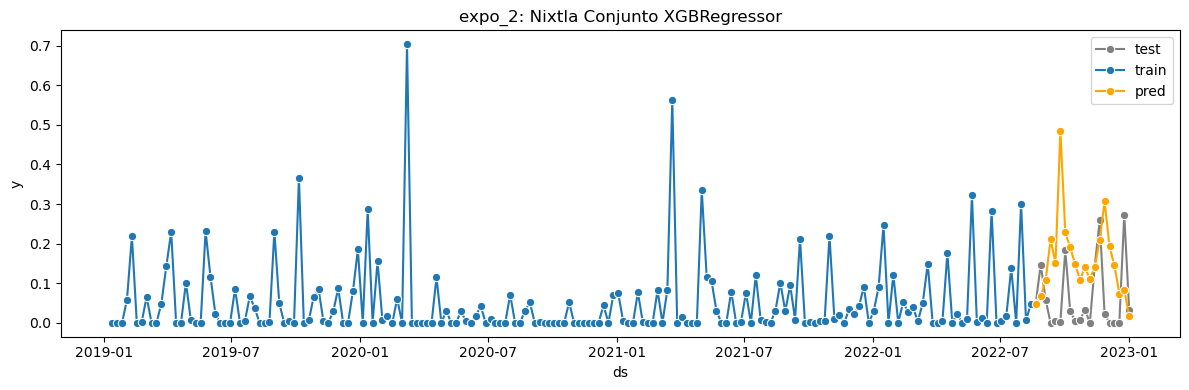

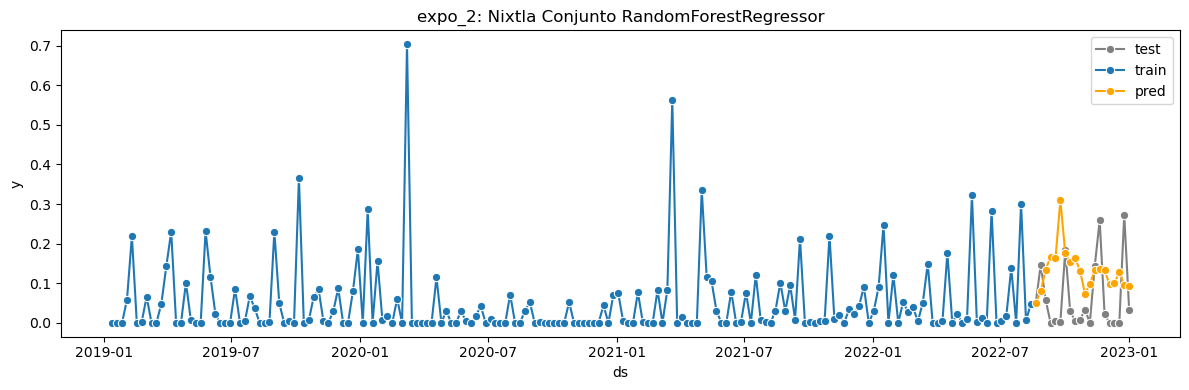

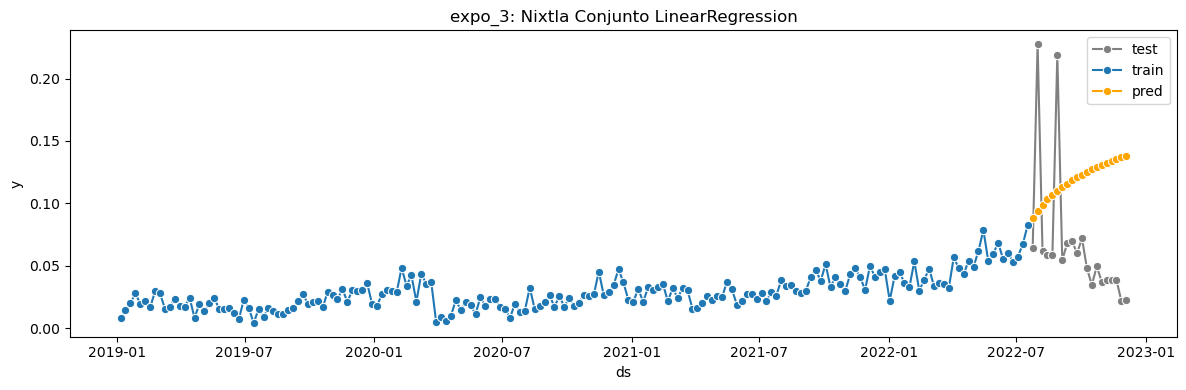

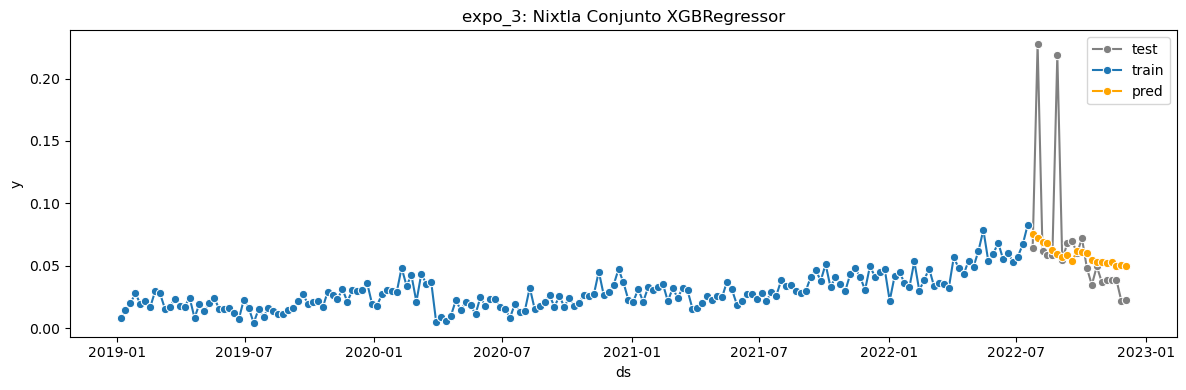

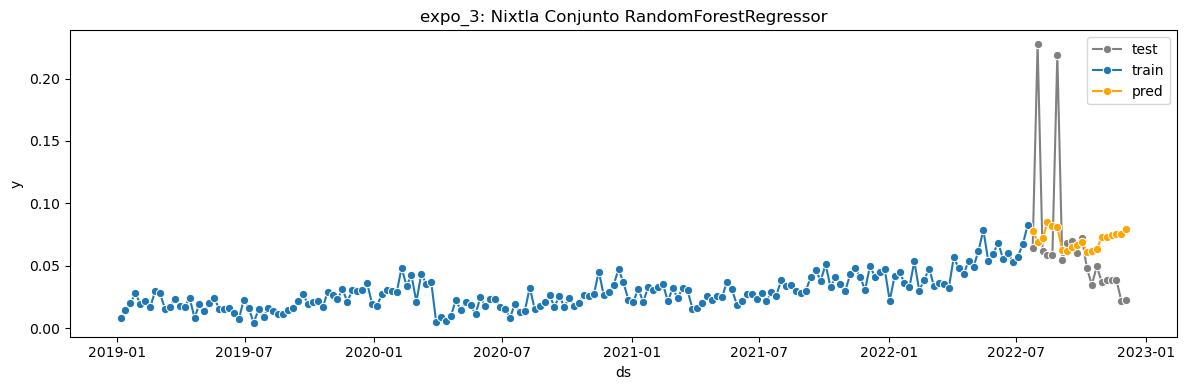

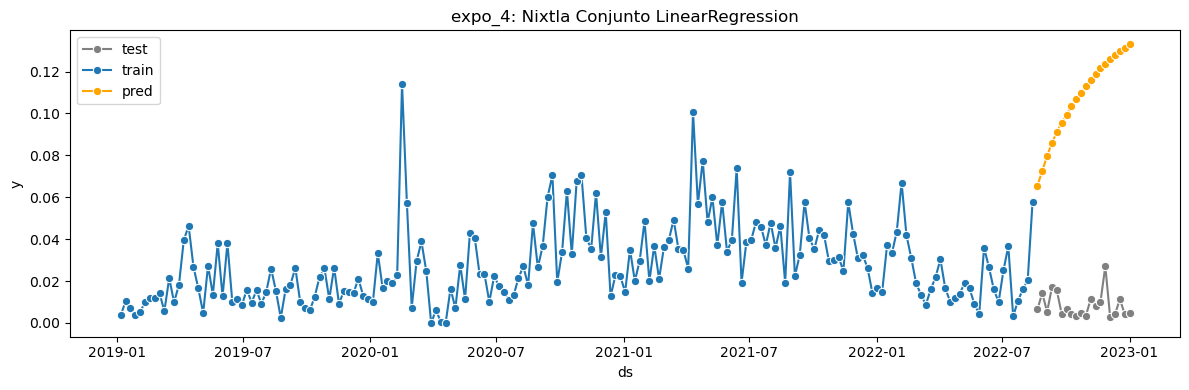

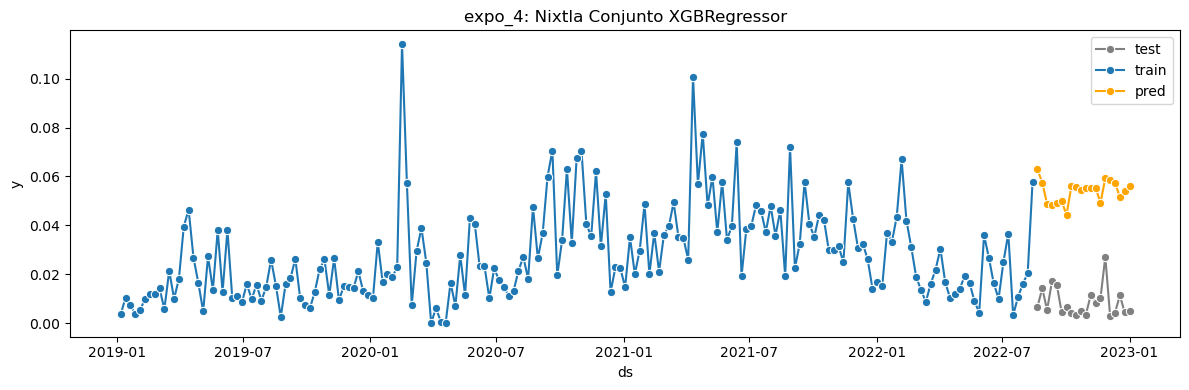

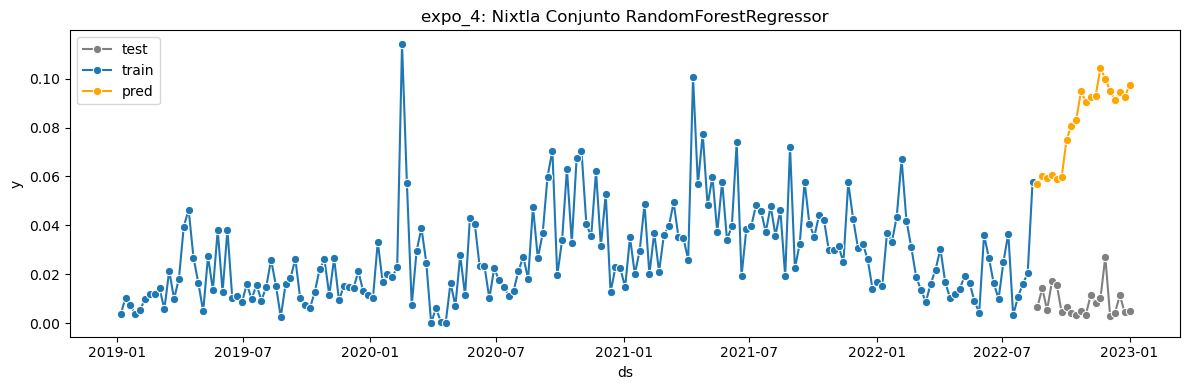

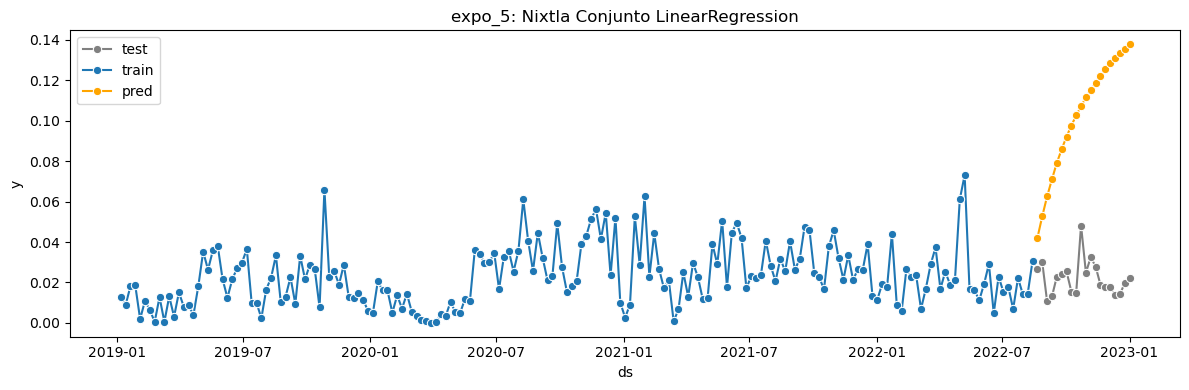

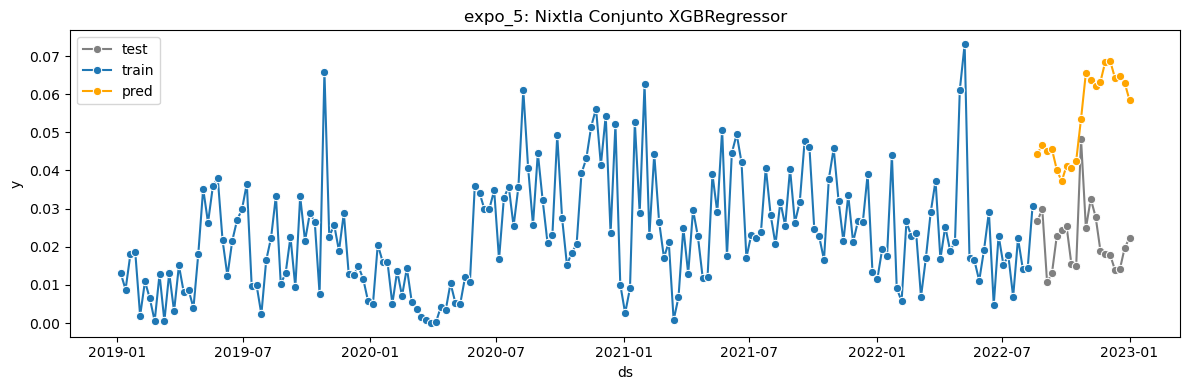

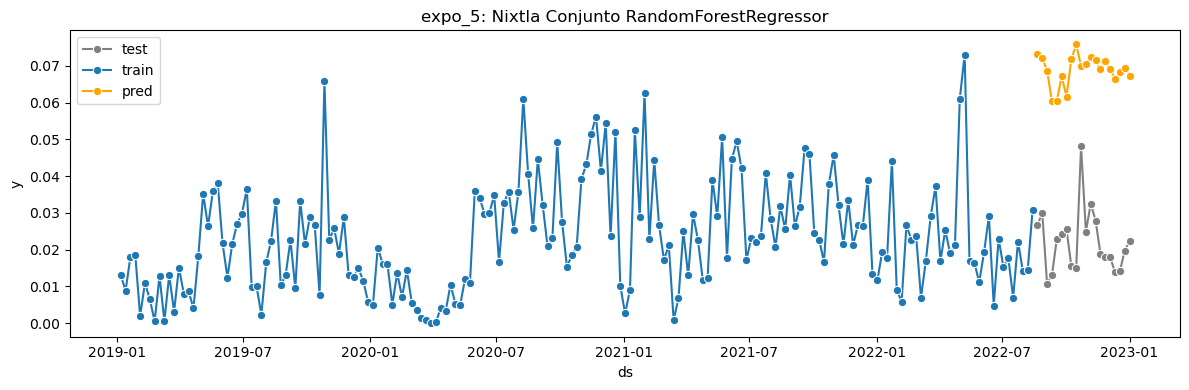

In [40]:
comparison_tbl= modelado_nixtla_conjunto(models, df_unificado, comparison_tbl)

In [41]:
best_models = comparison_tbl.groupby('Serie').apply(lambda group: group[group['RMSE'] == group['RMSE'].min()])
best_models.drop(columns='Serie', inplace=True)
best_models = best_models.groupby('Serie').first().reset_index()
best_models_sorted = best_models.sort_values(by='RMSE', ascending=True)
best_models_sorted.head(12)

Serie                                  Modelo       MAE      RMSE  \
23  impo_7  Nixtla Conjunto: RandomForestRegressor  0.016919  0.022095   
16  expo_5           Nixtla Conjunto: XGBRegressor  0.031875  0.034750   
20  impo_4           Nixtla Conjunto: XGBRegressor  0.041350  0.043068   
15  expo_4           Nixtla Conjunto: XGBRegressor  0.045406  0.046038   
14  expo_3           Nixtla Conjunto: XGBRegressor  0.026805  0.051588   
19  impo_3           Nixtla Conjunto: XGBRegressor  0.060821  0.062576   
22  impo_6       Nixtla Conjunto: LinearRegression  0.065866  0.071579   
21  impo_5       Nixtla Conjunto: LinearRegression  0.055430  0.079274   
17  impo_1  Nixtla Conjunto: RandomForestRegressor  0.071346  0.086761   
13  expo_2       Nixtla Conjunto: LinearRegression  0.087889  0.095591   
18  impo_2       Nixtla Conjunto: LinearRegression  0.115679  0.120288   
12  expo_1       Nixtla Conjunto: LinearRegression  0.114465  0.126740   

       sMAPE Processing Time  
23  0.331057          4.7981  
16  0.846129          4.7981  
20  1.346910          4.7981  
15  1.479302          4.7981  
14  0.342692          4.7981  
19  1.824602          4.7981  
22  1.147785          4.7981  
21  0.471405          4.7981  
17  0.188440          4.7981  
13  1.263853          4.7981  
18  1.049377          4.7981  
12  0.657632          4.7981

##### 2.1 Modelos ML: 
__Conclusion:__

El hecho de entrenar las series en conjunto mejoro los resultados obtenidos previamente para la mayoria de las series se observa que los modelos de ML aunque los resultados son mejores que para los modelos clasicos, los resultados no son optimos ya que en la mayoria de las series el modelo no logra predecir con certeza los kilos para las proximas 20 semanas, tal como se observa en las graficas obtenidas con los resultados. Por ello, en la siguiente seccion se buscaran mejorar los resultados con modelos de redes neuronales. 

Exporto el df con los resultados: 

In [42]:
comparison_tbl.to_csv('Data/Modelado/comparison_tbl.csv',index=False)